# Churn Customer Clustering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# data source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
# data licence: https://github.com/IBM/telco-customer-churn-on-icp4d
#import sys
#!{sys.executable} -m pip install kmodes

import random
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples

# import umap
# import umap.plot as uplot

from numba import njit

random.seed(42)
sns.set_theme()

In [ ]:
# Remove all umap-related packages
!pip uninstall umap umap-learn -y

# Clear any cached modules
import sys
modules_to_remove = [key for key in sys.modules.keys() if 'umap' in key]
for module in modules_to_remove:
    del sys.modules[module]

# Reinstall umap-learn
!pip install umap-learn

# Now try importing with the full path
import umap.umap_ as umap
# import umap.plot as umap_plot

Found existing installation: umap-learn 0.5.9.post2
Uninstalling umap-learn-0.5.9.post2:
  Successfully uninstalled umap-learn-0.5.9.post2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install kneed

In [ ]:
!pip install kmodes

In [ ]:
!pip install gower

In [ ]:
from kneed import KneeLocator
from kmodes.kprototypes import KPrototypes
import gower

# Dataset description

The Telco Churn Dataset is a customer behavior dataset that includes information about a telecommunications company's customers and whether or not they discontinued their services within the last month (churned). The dataset is typically used to create predictive models to identify customers who are likely to churn in the future.

- **customerID**: This is a unique identifier for each customer in the dataset.

- **gender**: This indicates the gender of the customer, typically "Male" or "Female".
- **SeniorCitizen**: This is a binary indicator of whether the customer is a senior citizen or not.
- **Partner**: This is a binary indicator of whether the customer has a partner or not.
- **Dependents**: This is a binary indicator of whether the customer has any dependents or not.
- **tenure**: This represents the number of months the customer has been with the company.
- **PhoneService**: This is a binary indicator of whether the customer has a phone service or not.
- **MultipleLines**: This indicates whether the customer has multiple telephone lines.
- **InternetService**: This describes the type of internet service the customer has, typically DSL, Fiber optic, or None.
- **OnlineSecurity**: This is a binary indicator of whether the customer has online security services or not.
- **OnlineBackup**: This is a binary indicator of whether the customer has online backup services or not.
- **DeviceProtection**: This is a binary indicator of whether the customer has device protection services or not.
- **TechSupport**: This is a binary indicator of whether the customer has technical support services or not.
- **StreamingTV**: This is a binary indicator of whether the customer has streaming TV services or not.
- **StreamingMovies**: This is a binary indicator of whether the customer has streaming movie services or not.
- **Contract**: This describes the type of contract the customer has with the company, typically Month-to-month, One year, or Two year.
- **PaperlessBilling**: This is a binary indicator of whether the customer has opted for paperless billing or not.
- **PaymentMethod**: This describes the payment method that the customer uses, such as Electronic check, Mailed check, Bank transfer (automatic), or Credit card (automatic).
- **MonthlyCharges**: This represents the amount charged to the customer monthly.
- **TotalCharges**: This represents the total amount charged to the customer.
- **Churn**: This is a binary indicator of whether the customer churned (discontinued their services) in the last month or not.

Citation : IBM Sample Data Sets - Telco customer churn

# Distance Metrics

In [ ]:
# euclidean and hammer distance

# Two observations with only categorical variables
person_A = ['Male', 'NYC', 'Married', 'College']
person_B = ['Male', 'LA',  'Single',  'College']

# Hamming distance approach:
mismatches = sum(a != b for a, b in zip(person_A, person_B))  # = 2
hamming_distance = mismatches / len(person_A)  # = 2/4 = 0.5

# # Gower distance approach (categorical part):
# gower_similarity = mismatches / len(person_A)  # = 2/4 = 0.5
# gower_distance = 1 - gower_similarity  # = 0.5

# Euclidean distance approach (numerical data):
person_C = [25, 50000, 3.2, 160]  # Age, Income, GPA, Height
person_D = [30, 60000, 3.5, 165]  # Age, Income, GPA, Height

euclidean_distance = np.sqrt(sum((c - d)**2 for c, d in zip(person_C, person_D)))
# = sqrt((25-30)² + (50000-60000)² + (3.2-3.5)² + (160-165)²)
# = sqrt(25 + 100000000 + 0.09 + 25) ≈ 10000.001

print(f'Hamming distance: {hamming_distance}')
# print(f'Gower similarity: {gower_similarity}')
# print(f'Gower distance: {gower_distance}')
print(f'Euclidean distance: {euclidean_distance}')

Hamming distance: 0.5
Euclidean distance: 10000.002504499687


In [ ]:
import numpy as np

# Two observations with mixed data: floats + nominal categorical (encoded)
# Features: Age, Income, GPA, City_encoded, Status_encoded, Education_encoded
person_A = [25.5, 52500.75, 3.25, 0, 1, 2]  # NYC=0, Married=1, Masters=2
person_B = [28.2, 48200.50, 3.78, 1, 0, 1]  # LA=1, Single=0, Bachelors=1

# Data ranges for numerical features
age_range = 65.0 - 18.0        # 18 to 65
income_range = 120000 - 25000  # 25K to 120K
gpa_range = 4.0 - 0.0          # 0.0 to 4.0

# Numerical similarities
age_similarity = 1 - abs(25.5 - 28.2) / age_range           # 1 - 2.7/47 = 0.943
income_similarity = 1 - abs(52500.75 - 48200.50) / income_range  # 1 - 4300.25/95000 = 0.955
gpa_similarity = 1 - abs(3.25 - 3.78) / gpa_range           # 1 - 0.53/4.0 = 0.868

# Categorical similarities (checks for exact match, 0 if not)
city_similarity = 1 if 0 == 1 else 0      # NYC vs LA = 0
status_similarity = 1 if 1 == 0 else 0    # Married vs Single = 0
education_similarity = 1 if 2 == 1 else 0 # Masters vs Bachelors = 0

# Overall Gower similarity and distance
all_similarities = [age_similarity, income_similarity, gpa_similarity,
                   city_similarity, status_similarity, education_similarity]
gower_similarity = sum(all_similarities) / len(all_similarities)  # (0.943 + 0.955 + 0.868 + 0 + 0 + 0) / 6 = 0.461
gower_distance = 1 - gower_similarity  # 1 - 0.461 = 0.539

print(f'All Similarities{all_similarities}')
print(f'Gower similarity: {gower_similarity}')
print(f'Gower distance: {gower_distance}')

All Similarities[0.9425531914893617, 0.9547342105263158, 0.8675, 0, 0, 0]
Gower similarity: 0.4607979003359463
Gower distance: 0.5392020996640536


# Data loading and preprocessing

In [ ]:
# Load the data
telco_path = '/content/drive/MyDrive/Colab/Datasets/telco-customer-churn.csv'
# telco_path = '/data/telco-customer-churn.csv' # USE THIS PATH LOCALLY

telco_df = pd.read_csv(telco_path)
telco_df = telco_df.drop_duplicates().reset_index(drop=True)

In [ ]:
# Dataset shape
telco_df.shape

(7043, 21)

In [ ]:
# Check for missing values
telco_df.isnull().sum(axis=0)

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
telco_df['SeniorCitizen'] = telco_df['SeniorCitizen'].astype(int).astype('object')

In [ ]:
# Remove rows with non existing TotalCharges
telco_df = telco_df[telco_df['TotalCharges']!=' ']
telco_df['TotalCharges'] = telco_df['TotalCharges'].astype(float)

In [ ]:
# Get copy of dataframe in order to preserve original values for cluster analysis
original_df = telco_df.copy()
original_df.shape

(7032, 21)

In [ ]:
# Remove columns that will not be used for clustering
other_cols = ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']
other_df = telco_df.loc[:, other_cols]
telco_df = telco_df.dropna().drop(columns=other_cols)

In [ ]:
# Describe numerical attributes of the data
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


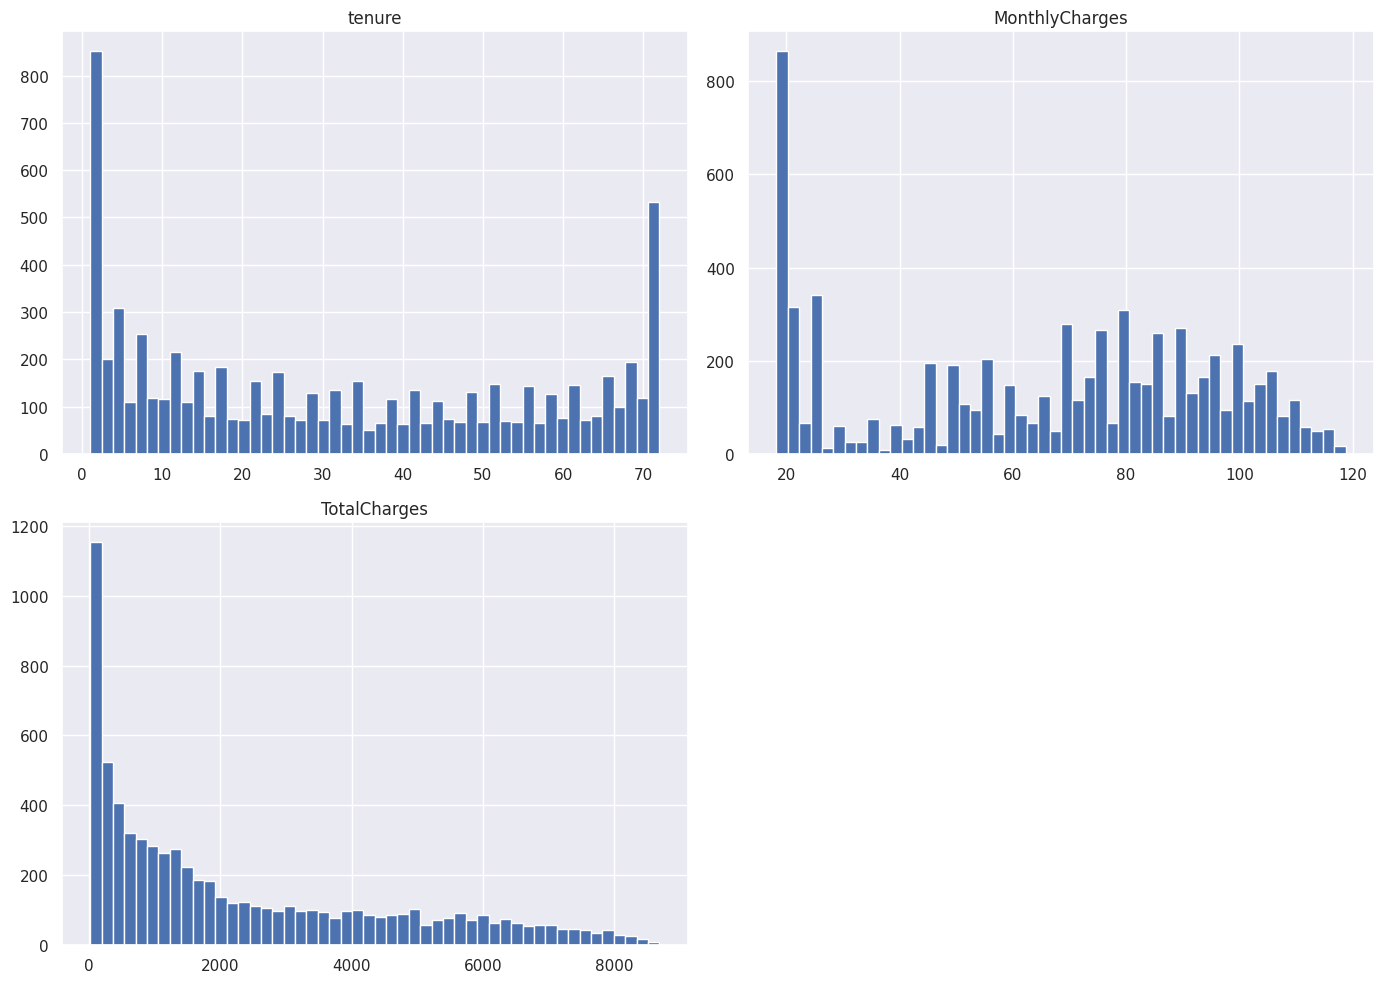

In [ ]:
# Plot numerical variables
_ = telco_df.hist(bins=50, figsize=(14,10))

# This ensures the subplots do not overlap
plt.tight_layout()
plt.show()

In [ ]:
# check variable skew
print(telco_df['TotalCharges'].skew())
print(telco_df['MonthlyCharges'].skew())
print(telco_df['tenure'].skew())

0.9616424997242504
-0.22210292770166232
0.23773083190513133


# Categorical Feature Distributions

In [ ]:
# Plot categorical columns
def plot_categorical_features(df):
    categ_cols = df.select_dtypes(include=['object']).columns
    num_plots = len(categ_cols)

    # Determine number of rows needed for the grid
    num_rows = math.ceil(num_plots / 3.0)

    # Create subplots
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

    # Flatten the axes array if there's more than one row
    axs = axs.flatten()

    # Plot data
    for i, column in enumerate(categ_cols):
        ax = axs[i]
        df[column].value_counts().plot(
            kind='bar',
            ax=ax,
            title=column,
            xlabel=''
        )

    plt.tight_layout()

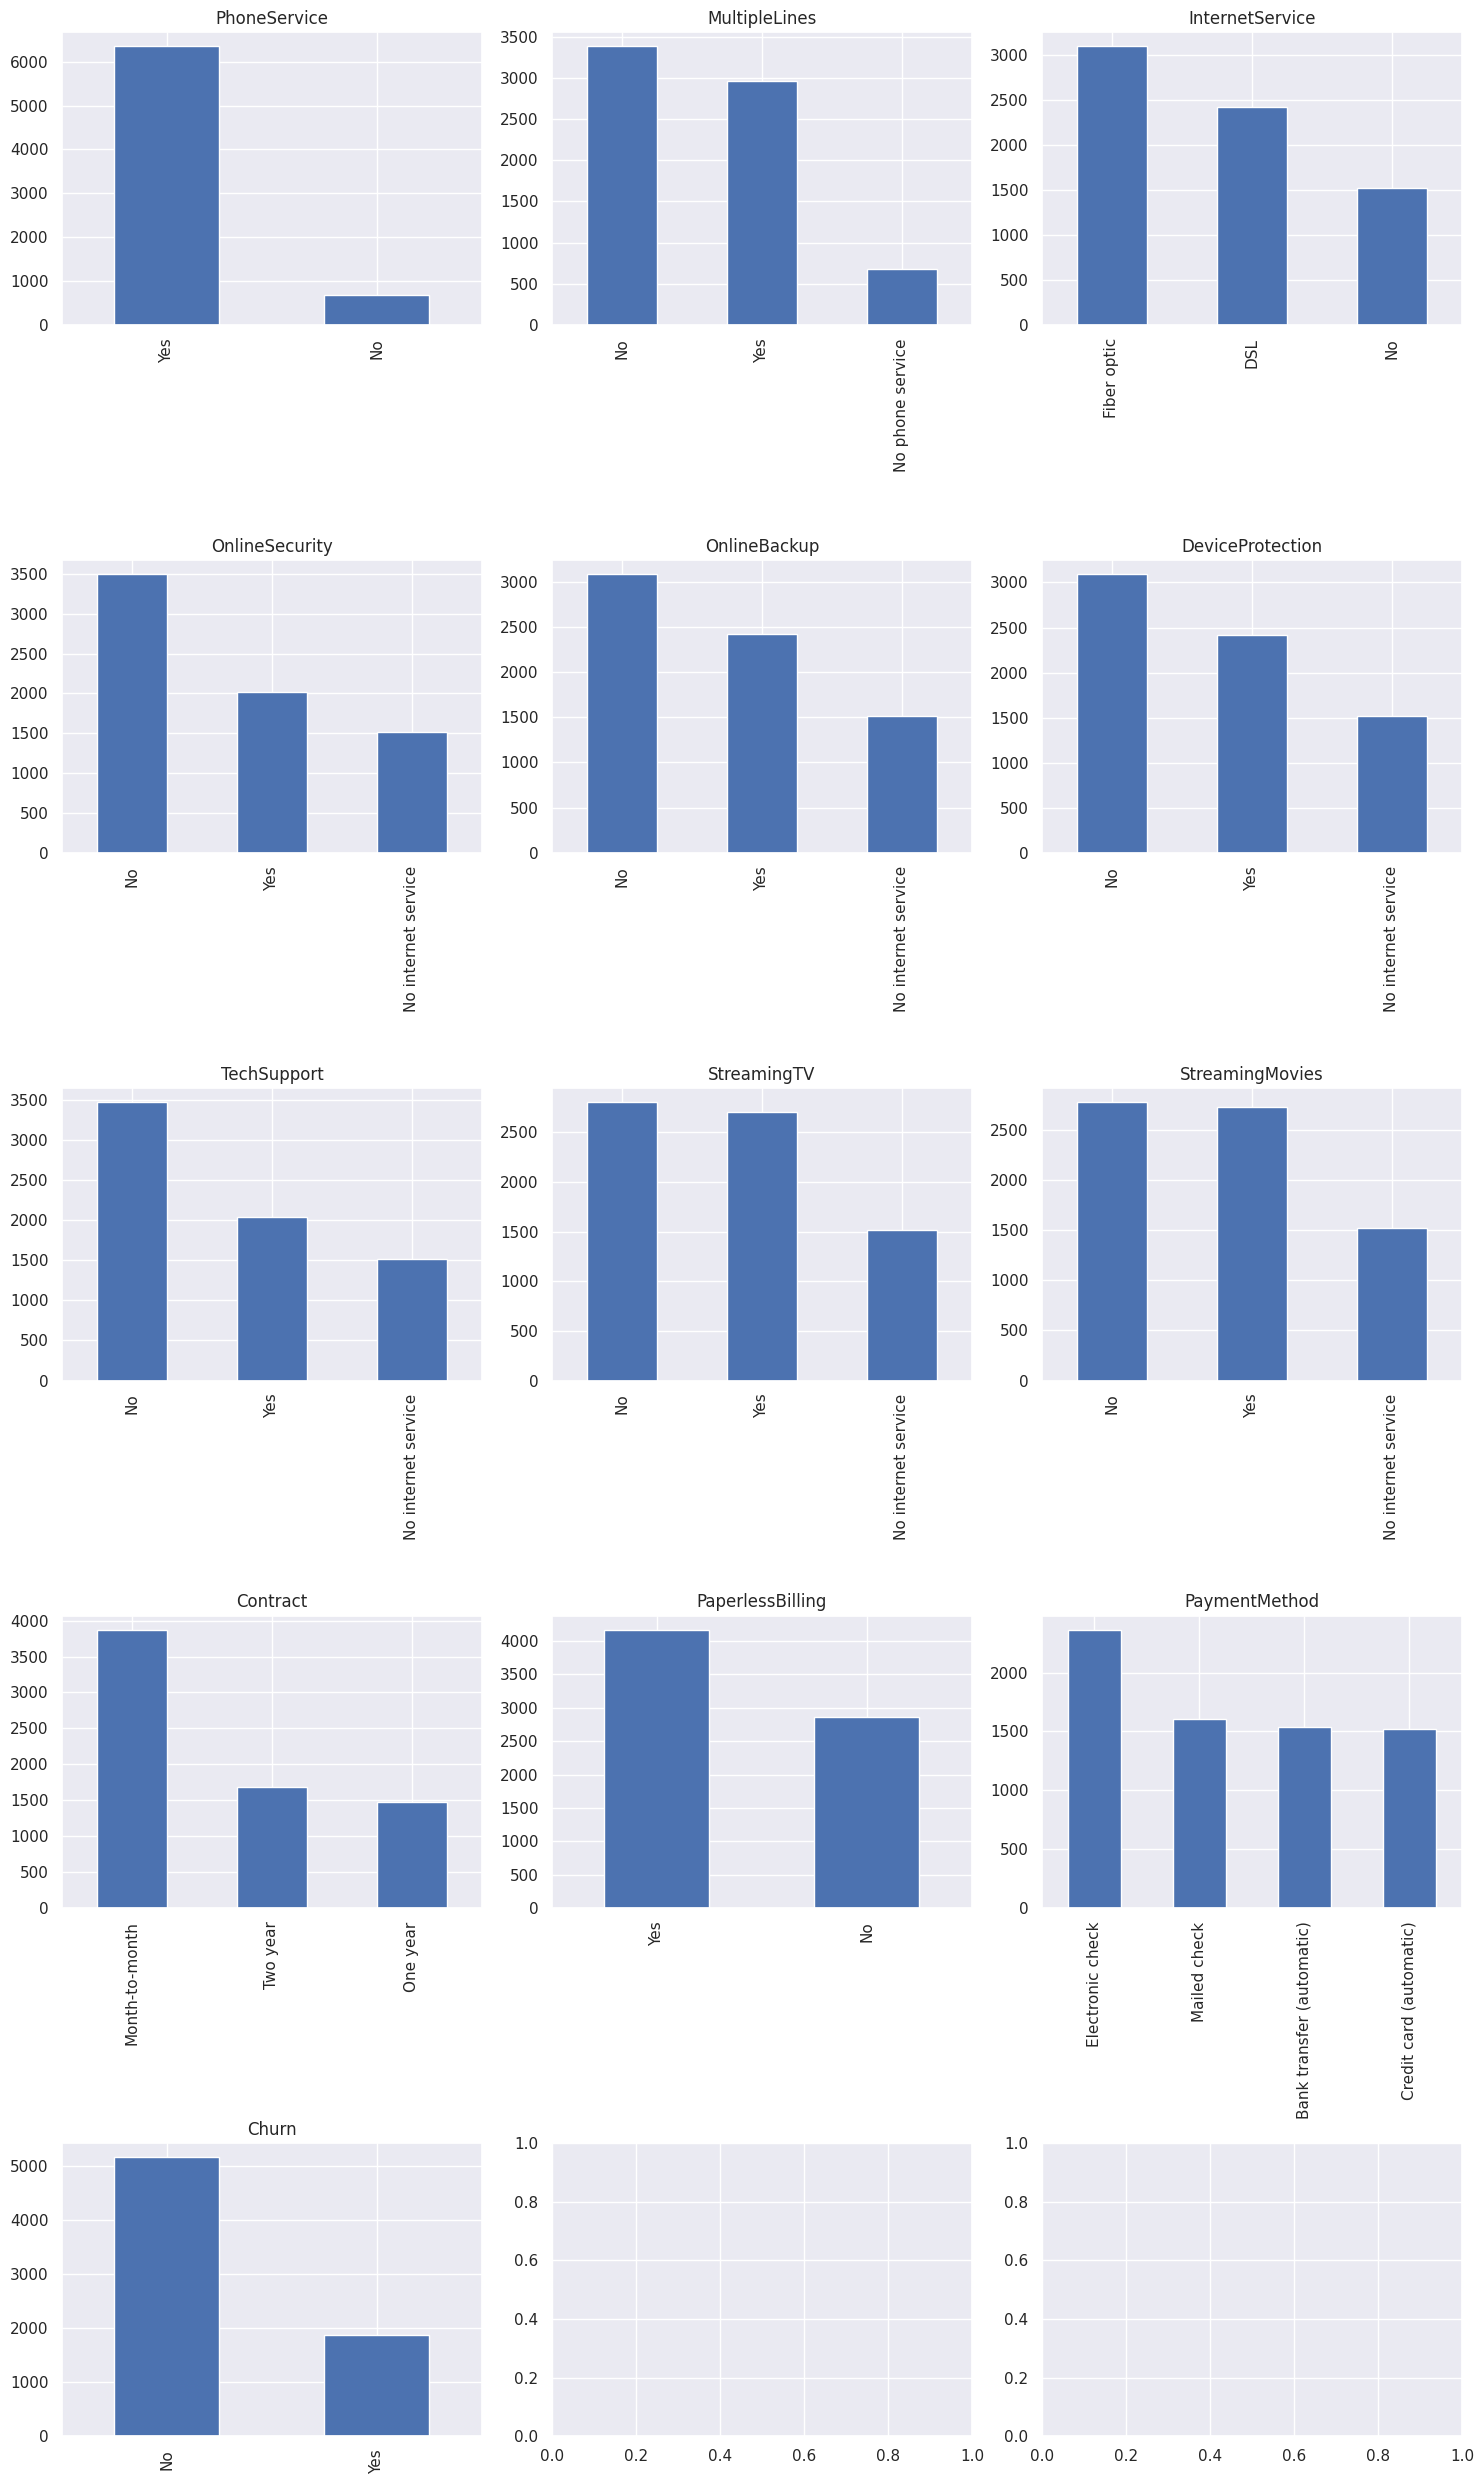

In [ ]:
plot_categorical_features(telco_df)

# Numeric Feature Analysis

In [ ]:
# Get numerical and categorical columns
categ_cols = telco_df.select_dtypes(include=['object']).columns
num_cols = list(set(telco_df.columns)-set(categ_cols))

# Scale numerical columns
print(telco_df['TotalCharges'].skew())
telco_df['TotalCharges'] = np.sqrt(telco_df['TotalCharges'])
print(telco_df['TotalCharges'].skew())

0.9616424997242504
0.3089261418986736


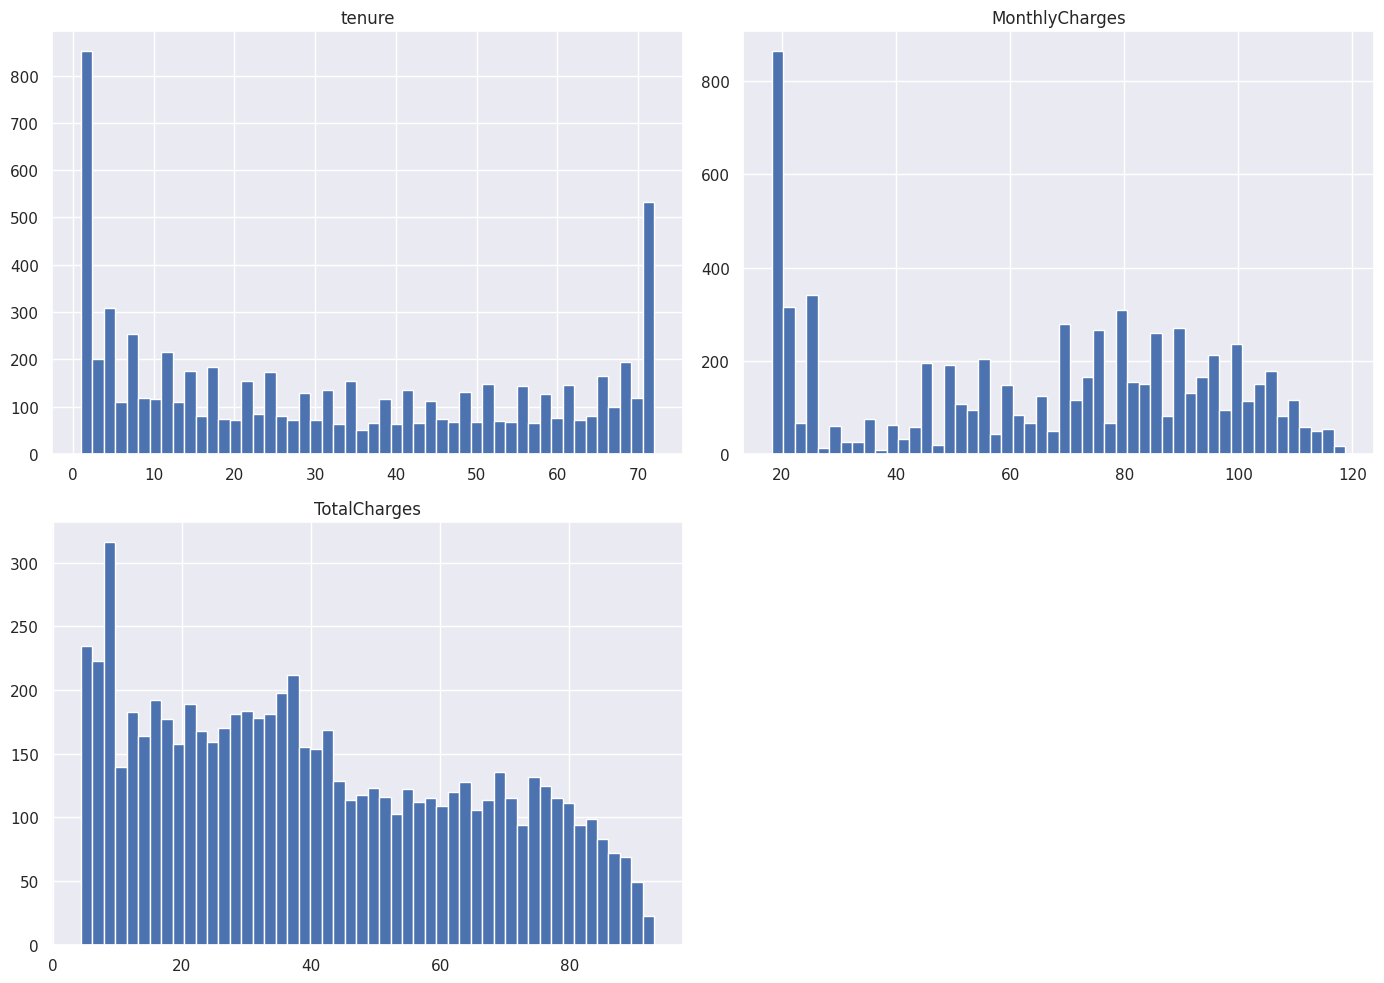

In [ ]:
# Plot numerical variables
_ = telco_df.hist(bins=50, figsize=(14,10))

# This line ensures the subplots do not overlap
plt.tight_layout()
plt.show()

In [ ]:
# Scale numerical columns
standard_scaler = MinMaxScaler()
telco_df[num_cols] = standard_scaler.fit_transform(telco_df[num_cols])

# Encode categorical columns
ord_encoder = OrdinalEncoder(dtype=np.int32)
telco_df[categ_cols] = ord_encoder.fit_transform(telco_df[categ_cols])

In [ ]:
print(telco_df.shape)
telco_df.head()

(7032, 16)


,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0.000000,0,1,0,0,2,0,0,0,0,0,1,2,0.115423,0.012690,0
1,0.464789,1,0,0,2,0,2,0,0,0,1,0,3,0.385075,0.440402,0
2,0.014085,1,0,0,2,2,0,0,0,0,0,1,3,0.354229,0.068241,1
3,0.619718,0,1,0,2,0,2,2,0,0,1,0,0,0.239303,0.434049,0
4,0.014085,1,0,1,0,0,0,0,0,0,0,1,2,0.521891,0.089794,1


In [ ]:
# Describe numerical attributes of the data
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,0.442560,0.345708,0.0,0.112676,0.394366,0.760563,1.0
PhoneService,7032.0,0.903299,0.295571,0.0,1.000000,1.000000,1.000000,1.0
MultipleLines,7032.0,0.940557,0.948627,0.0,0.000000,1.000000,2.000000,2.0
InternetService,7032.0,0.872582,0.737271,0.0,0.000000,1.000000,1.000000,2.0
OnlineSecurity,7032.0,0.789249,0.859962,0.0,0.000000,1.000000,2.000000,2.0
OnlineBackup,7032.0,0.905859,0.880394,0.0,0.000000,1.000000,2.000000,2.0
DeviceProtection,7032.0,0.903868,0.880178,0.0,0.000000,1.000000,2.000000,2.0
TechSupport,7032.0,0.796359,0.861674,0.0,0.000000,1.000000,2.000000,2.0
StreamingTV,7032.0,0.984926,0.885285,0.0,0.000000,1.000000,2.000000,2.0
StreamingMovies,7032.0,0.992890,0.885385,0.0,0.000000,1.000000,2.000000,2.0


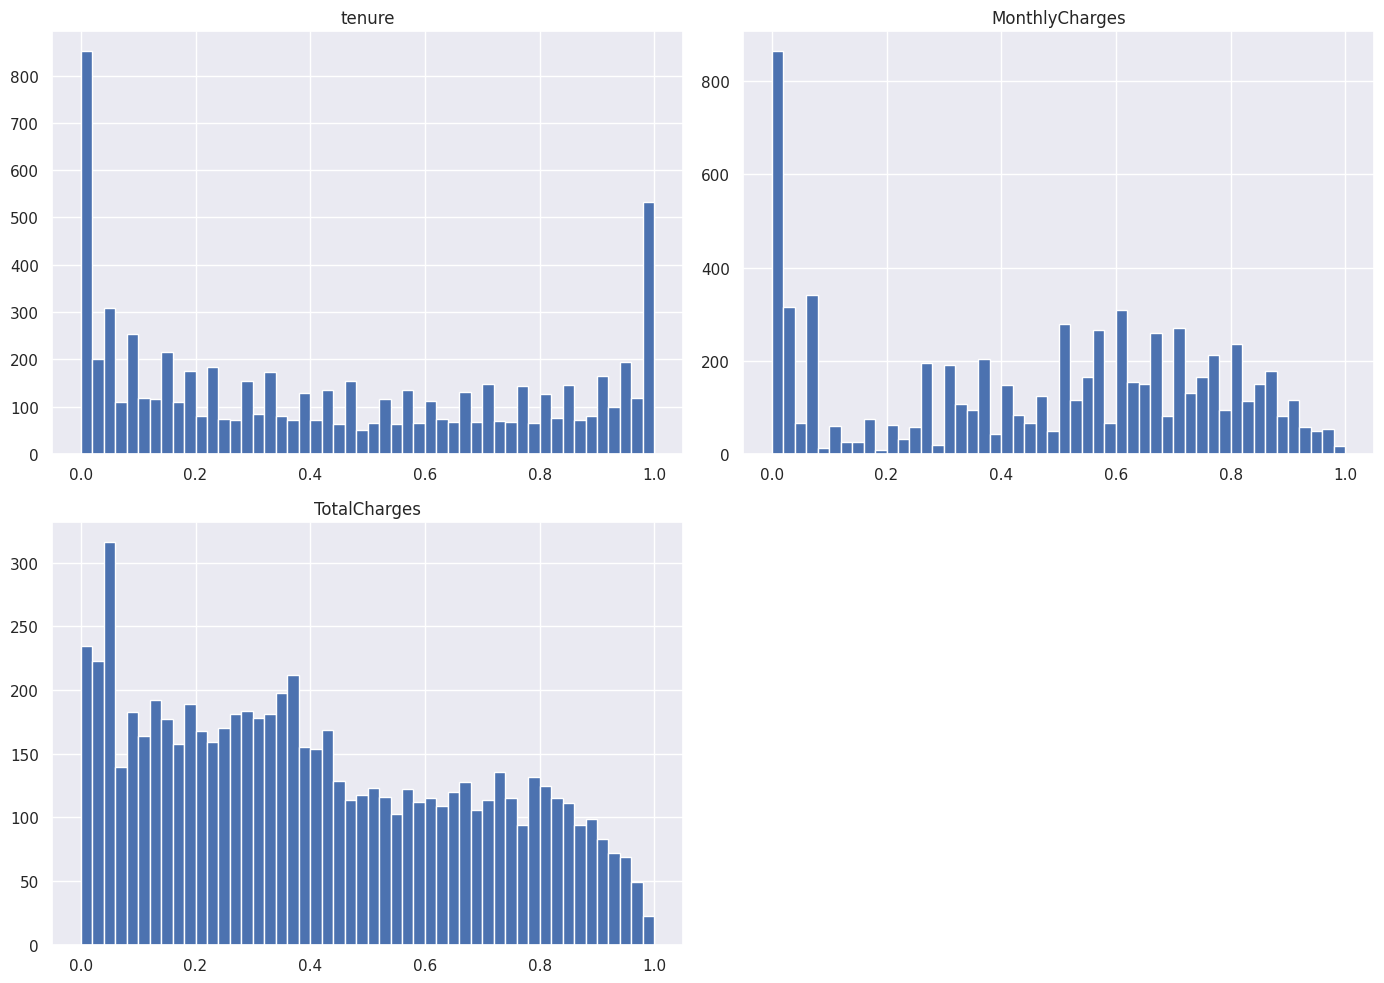

In [ ]:
# Plot numerical variables
_ = telco_df[['tenure', 'MonthlyCharges', 'TotalCharges']].hist(bins=50, figsize=(14,10))

# This line ensures the subplots do not overlap
plt.tight_layout()
plt.show()

# Correlation Matrix

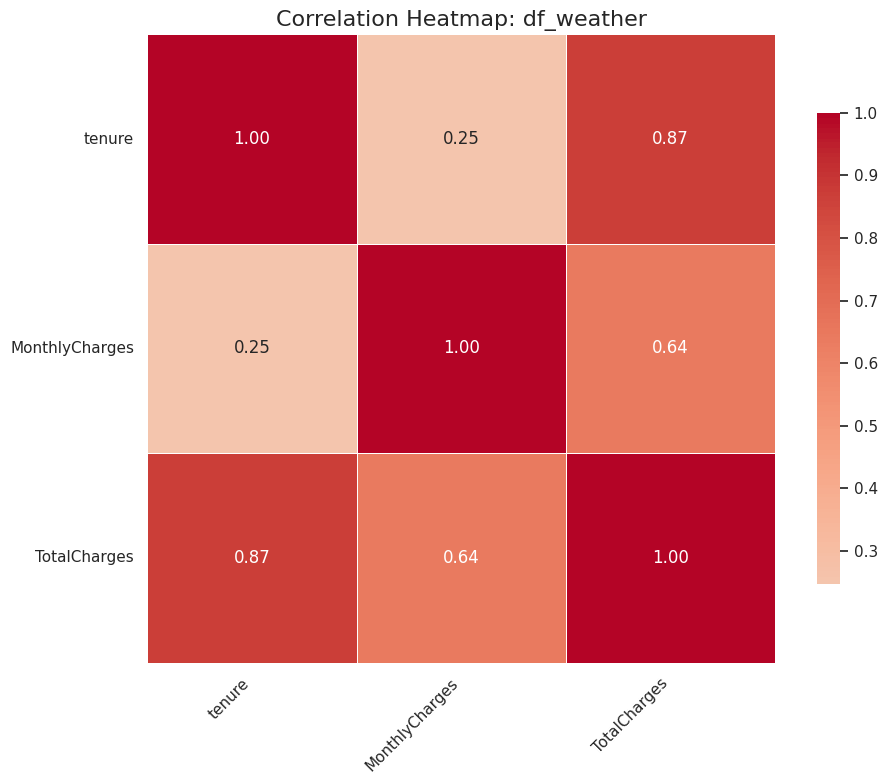

In [ ]:
# correlation matrix
cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
corr_matrix = telco_df[cols].corr(numeric_only=True)  # Use numeric_only=True for pandas >=1.5

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       # Show correlation coefficients
    cmap='coolwarm',  # Color map
    center=0,         # Center the colormap at zero
    fmt=".2f",        # Format the numbers to 2 decimal places
    square=True,      # Make cells square
    linewidths=0.5,   # Cell border lines
    cbar_kws={"shrink": 0.75}  # Shrink color bar
)
plt.title("Correlation Heatmap: df_weather", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Get positions of categorical and numerical columns
df_cols = list(telco_df.columns)

numerical_idx = np.array(
    [idx for idx, element in enumerate(df_cols) if element in num_cols]
)

categ_idx = np.array(
    [idx for idx, element in enumerate(df_cols) if element in categ_cols]
)

categ_bool = [True if element in categ_cols else False for element in df_cols]

print(numerical_idx)
print(categ_idx)
print(categ_bool)

[ 0 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12 15]
[False, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True]


# UMAP

## Gower Distance Matrix

* precompute distance matrix bc gower uses different distance metrics for by feature type:
  * numeric features: Euclidean distance
  * categorical features: Hamming distance (categorical matching)

In [ ]:
pairwise_gower = gower.gower_matrix(telco_df, cat_features=categ_bool)
print(pairwise_gower.shape)

(7032, 7032)


In [ ]:
pd.DataFrame(pairwise_gower).iloc[:, :5].describe()

,0,1,2,3,4
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.556727,0.509889,0.521195,0.602683,0.486802
std,0.178751,0.129109,0.166996,0.148476,0.221983
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.416810,0.423537,0.395496,0.502511,0.298632
50%,0.560826,0.530796,0.529841,0.627861,0.501232
75%,0.708712,0.607769,0.653409,0.716428,0.673938
max,0.972588,0.817240,0.893544,0.910406,0.918027


## UMAP Parameters

| Parameter | Description | Possible Values (Default in **bold**) |
|-----------|-------------|---------------------------------------|
| `n_components` | Dimensionality of the reduced dimension space | Positive integers (**2**) |
| `n_neighbors` | Number of neighboring points used in local approximations of manifold structure | Integers 2-200 (**15**) |
| `min_dist` | Minimum distance apart that points are allowed to be in the low dimensional representation | Floats 0.0-0.99 (**0.1**) |
| `metric` | Distance metric to use for the input space | 'euclidean', 'manhattan', 'chebyshev', 'minkowski', 'canberra', 'braycurtis', 'mahalanobis', 'wminkowski', 'seuclidean', 'cosine', 'correlation', 'haversine', 'hamming', 'jaccard', 'dice', 'russelrao', 'kulsinski', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', or callable (**'euclidean'**) |
| `random_state` | Random seed used for the random number generator | Integer or None (**None**) |
| `spread` | Effective scale of embedded points | Positive floats (**1.0**) |
| `learning_rate` | Learning rate for the SGD optimizer | Positive floats (**1.0**) |
| `n_epochs` | Number of training epochs for optimization | Positive integers or None for auto (**None**) |
| `init` | How to initialize the low dimensional embedding | 'spectral', 'random', numpy array of initial positions (**'spectral'**) |
| `negative_sample_rate` | Number of negative samples to select per positive sample in optimization process | Non-negative integers (**5**) |
| `repulsion_strength` | Weighting applied to negative samples in low dimensional embedding optimization | Positive floats (**1.0**) |
| `local_connectivity` | Local connectivity required (minimum number of nearest neighbor pairs) | Non-negative integers (**1**) |
| `set_op_mix_ratio` | Interpolates between fuzzy union and intersection as the set operation used to combine local fuzzy simplicial sets | Floats 0.0-1.0 (**1.0**) |
| `low_memory` | Use a lower memory, but more computationally expensive approach | **False**, True |
| `verbose` | Controls verbosity of logging | **False**, True |
| `target_weight` | Weighting factor between data topology and target topology | Floats 0.0-1.0 (**0.5**) |
| `target_n_neighbors` | Number of nearest neighbors to use to construct the target simplicial set | Integers ≥ 1 or -1 for n_neighbors (**-1**) |
| `target_metric` | Distance metric to use for the target space | Same options as `metric` (**'categorical'**) |
| `angular_rp_forest` | Use angular random projection forests for initialization | **False**, True |
| `unique` | Controls if the algorithm should check for duplicate points | **False**, True |
| `transform_queue_size` | For transform operations, controls underlying Numba compilation | Positive floats (**4.0**) |
| `transform_seed` | Random seed used for transform operation | Integer or None (**42**) |
| `a` | More specific parameters controlling the embedding | Positive floats or None for auto (**None**) |
| `b` | More specific parameters controlling the embedding | Positive floats or None for auto (**None**) |

In [ ]:
# Embed with umap
# UMAP using precomputed distance metric maxtr(pairwise_gower)
umap_model = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    random_state=42,
    metric='precomputed', # precomputed distance matrix
    min_dist=0.3
)
umap_emb_data = umap_model.fit_transform(pairwise_gower)

# uplot.points(umap_model)

In [ ]:
print(umap_emb_data.shape)
umap_emb_data

(7032, 2)


array([[ 4.44001   , 13.735526  ],
       [ 9.173754  ,  1.7516385 ],
       [ 8.75269   ,  3.6665056 ],
       ...,
       [ 4.4372606 , 13.463741  ],
       [14.660559  ,  7.0129414 ],
       [14.367618  , -0.17995934]], dtype=float32)

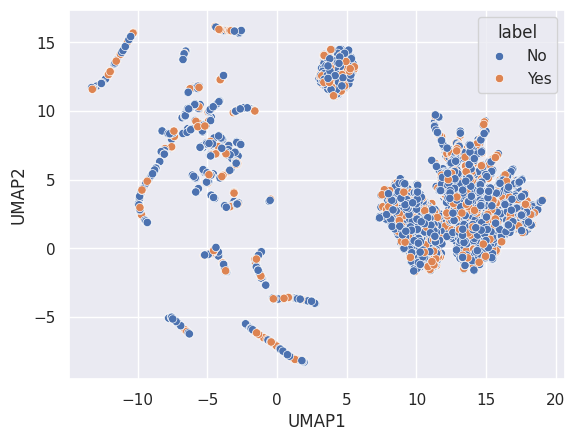

In [ ]:
# Plot embeded data
embedding_df = pd.DataFrame(umap_emb_data, columns=['UMAP1', 'UMAP2'])
embedding_df['label'] = original_df['Churn']
sns.scatterplot(embedding_df, x='UMAP1', y='UMAP2', hue='label');

In [ ]:
# umap.plot.connectivity(umap_model, show_points=True)

In [ ]:
# umap.plot.diagnostic(umap_model, diagnostic_type='pca')

In [ ]:
# Embed with umap
# increased n_neighbors to capture more local structure
umap_model = umap.UMAP(
    n_neighbors=300,
    n_components=2,
    random_state=42,
    metric='precomputed',
    min_dist=0.3
)
umap_emb_data = umap_model.fit_transform(pairwise_gower)

# uplot.points(umap_model)

In [ ]:
# umap.plot.connectivity(umap_model, show_points=True)

In [ ]:
# umap.plot.diagnostic(umap_model, diagnostic_type='pca')

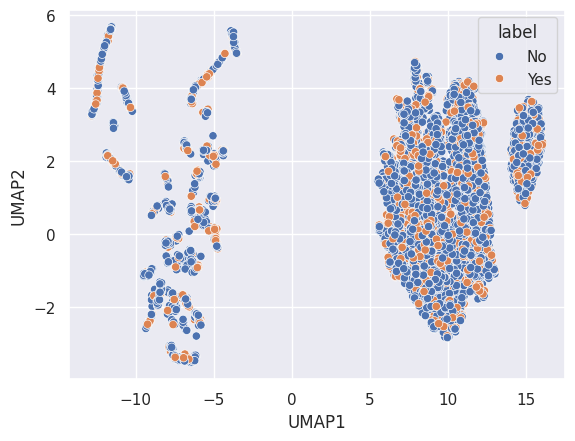

In [ ]:
# Plot embeded data
embedding_df = pd.DataFrame(umap_emb_data, columns=['UMAP1', 'UMAP2'])
embedding_df['label'] = original_df['Churn']
sns.scatterplot(embedding_df, x='UMAP1', y='UMAP2', hue='label');

## Customer Nearest Neighbors

In [ ]:
# compute nearest neighbors based on precomputed distance matrix (gower)
from sklearn.neighbors import NearestNeighbors

# Create NearestNeighbors object with precomputed metric
nbrs = NearestNeighbors(n_neighbors=15, metric='precomputed')
nbrs.fit(pairwise_gower)

# Get k-nearest neighbors
distances, indices = nbrs.kneighbors(pairwise_gower)

# Note: distances and indices will include each point as its own neighbor
# (at distance 0), so you might want to exclude the first column:
knn_indices = indices[:, 1:]  # Exclude self
knn_distances = distances[:, 1:]  # Exclude self-distance

In [ ]:
print(knn_indices.shape) # indices of top 15 nearest neighbors for each point
print(knn_distances.shape) # distances of the top 15 nearest neighbors

(7032, 14)
(7032, 14)


In [ ]:
knn_indices

array([[5136, 1905, 5550, ..., 3499, 3186, 6667],
       [2253,  291, 4010, ..., 5510, 6562,  536],
       [5261, 3368, 4269, ...,  235, 6097, 1256],
       ...,
       [6880,  841, 5122, ..., 4064, 5941, 3253],
       [6520, 3367, 2163, ..., 4655, 6959, 3749],
       [  72, 1581, 5401, ..., 2261, 6349, 1380]])

In [ ]:
knn_distances

array([[0.00487965, 0.00917756, 0.02172964, ..., 0.07844841, 0.08238418,
        0.08294857],
       [0.03008647, 0.06707092, 0.07102143, ..., 0.11765204, 0.1262479 ,
        0.12734173],
       [0.05953899, 0.06325671, 0.06536128, ..., 0.12554057, 0.12595116,
        0.1277485 ],
       ...,
       [0.01158874, 0.06590927, 0.06817695, ..., 0.07772317, 0.0839465 ,
        0.08415437],
       [0.00556014, 0.00587721, 0.00648559, ..., 0.06311157, 0.06338952,
        0.06377074],
       [0.06903282, 0.06913253, 0.07042391, ..., 0.08168685, 0.08767762,
        0.08923779]], dtype=float32)

In [ ]:
# compare first user and it's closest neighbor (lowest distance)
nn_index = int(knn_indices[0, 0])
original_df.iloc[0], original_df.iloc[nn_index]

(customerID                7590-VHVEG
 gender                        Female
 SeniorCitizen                      0
 Partner                          Yes
 Dependents                        No
 tenure                             1
 PhoneService                      No
 MultipleLines       No phone service
 InternetService                  DSL
 OnlineSecurity                    No
 OnlineBackup                     Yes
 DeviceProtection                  No
 TechSupport                       No
 StreamingTV                       No
 StreamingMovies                   No
 Contract              Month-to-month
 PaperlessBilling                 Yes
 PaymentMethod       Electronic check
 MonthlyCharges                 29.85
 TotalCharges                   29.85
 Churn                             No
 Name: 0, dtype: object,
 customerID                1078-TDCRN
 gender                        Female
 SeniorCitizen                      1
 Partner                          Yes
 Dependents              

---

# Mixed distance and k-prototypes

In [ ]:
xx = telco_df.loc[0].to_numpy()
yy = telco_df.loc[1].to_numpy()

In [ ]:
print(xx.shape)
print(yy.shape)

(16,)
(16,)


In [ ]:
telco_df[num_cols].std().mean()

np.float64(0.30708838925083487)

# Gamma Weight

* `gamma: 0 -> d(X, Y) = d_numerical(X, Y) + 0 × d_categorical(X, Y)`
  * Only numeric features matter
* `gamma: 1 -> d(X, Y) = d_numerical(X, Y) + 1 × d_categorical(X, Y)`
  * Features have equal weight
* `gamma: 0.5 -> d(X, Y) = d_numerical(X, Y) + 1 × d_categorical(X, Y)`
  * Categorical features have 0.5 weight

In [ ]:

# gamma based on mean standard deviation across numeric features
gamma = 1/2 * telco_df[num_cols].std().mean()
gamma

np.float64(0.15354419462541744)

In [ ]:
def kproto_dist(x, y, num_idx, categ_idx, gamma):

    euclidean_part = np.sum(np.square(x[num_idx] - y[num_idx]))
    hamming_part = np.sum(x[categ_idx] == y[categ_idx])

    return euclidean_part + gamma*hamming_part

In [ ]:
@njit
def kproto_dist_nmb(x, y, num_idx, categ_idx, gamma):

    euclidean_part = 0
    for i in num_idx:
        euclidean_part += (x[i] - y[i]) ** 2 ## np.sqrt()

    hamming_part = 0
    for i in categ_idx:
        if x[i] != y[i]:
            hamming_part += 1

    return euclidean_part + gamma * hamming_part

In [ ]:
%%timeit
kproto_dist_nmb(xx,yy,num_idx=numerical_idx, categ_idx=categ_idx, gamma=gamma)

The slowest run took 18.85 times longer than the fastest. This could mean that an intermediate result is being cached.
4.14 µs ± 6.83 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
kproto_dist(xx,yy,num_idx=numerical_idx, categ_idx=categ_idx, gamma=gamma)

13.7 µs ± 3.77 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


| Parameter | Description | Possible Values (Default in **bold**) |
|-----------|-------------|---------------------------------------|
| `X` | Input data array | Array-like of shape (n_samples, n_features) |
| `Y` | Second input data array (optional) | Array-like of shape (n_samples, n_features) or **None** |
| `metric` | Distance metric to use | 'euclidean', 'manhattan', 'cosine', 'l1', 'l2', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'precomputed', or callable (**'euclidean'**) |
| `n_jobs` | Number of parallel jobs to run | Integer or **None** (None = 1 job) |
| `force_all_finite` | Whether to raise error on non-finite values | **True**, False, 'allow-nan' |
| `**kwds` | Additional keyword arguments | Depends on metric (e.g., p for minkowski, V for mahalanobis) |

In [ ]:
kproto_pairwise = pairwise_distances(
    telco_df.to_numpy(), metric=kproto_dist_nmb,
    num_idx=numerical_idx, categ_idx=categ_idx,
    gamma=1
)

In [ ]:
print(kproto_pairwise.shape)

(7032, 7032)


In [ ]:
kproto_pairwise[0]

array([ 0.        ,  8.47167746,  5.06031251, ...,  2.04174388,
        6.2166656 , 13.16316278])

In [ ]:
pairwise_gower[0]

array([0.        , 0.57263446, 0.33177754, ..., 0.14320752, 0.41381934,
       0.84620655], dtype=float32)

In [ ]:
def plot_silouethes_score(
    data, clusters, ax, colormap=None,
    distance_measure='euclidean'
):

    y_lower = 10

    # Calculate average silhouette score
    silhouette_scr = silhouette_score(data, clusters, metric=distance_measure)

    # Calculate silhouette score for each data point
    sample_silhouette_values = silhouette_samples(data, clusters, metric=distance_measure)

    # Number of clusters
    num_clust = np.unique(clusters).shape[0]


    # Plot siluethe scores for points belonging to each cluster
    for clust_i in range(num_clust):

        # Get points bellogning to the current cluster
        ith_cluster_silhouette_values = sample_silhouette_values[
            clusters == clust_i
        ]

        # Sort points by silhouette value
        ith_cluster_silhouette_values.sort()

        # Get size of current cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        # Get upper value of y cooridnate for current cluster
        y_upper = y_lower + size_cluster_i

        # Fill values between y_lower and y_upper with silhouette score values
        # for data points

        if colormap:
            color = colormap[clust_i]
        else:
            color = cm.nipy_spectral(float(clust_i) / num_clust)

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(clust_i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax.axvline(x=silhouette_scr, color='r', linestyle='--')

    # Set title and labels for the silhouette subplot
    ax.set_yticklabels([])
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    return silhouette_scr

Performing clustering for k = 2
Performing clustering for k = 3
Performing clustering for k = 4
Performing clustering for k = 5
Performing clustering for k = 6
Performing clustering for k = 7


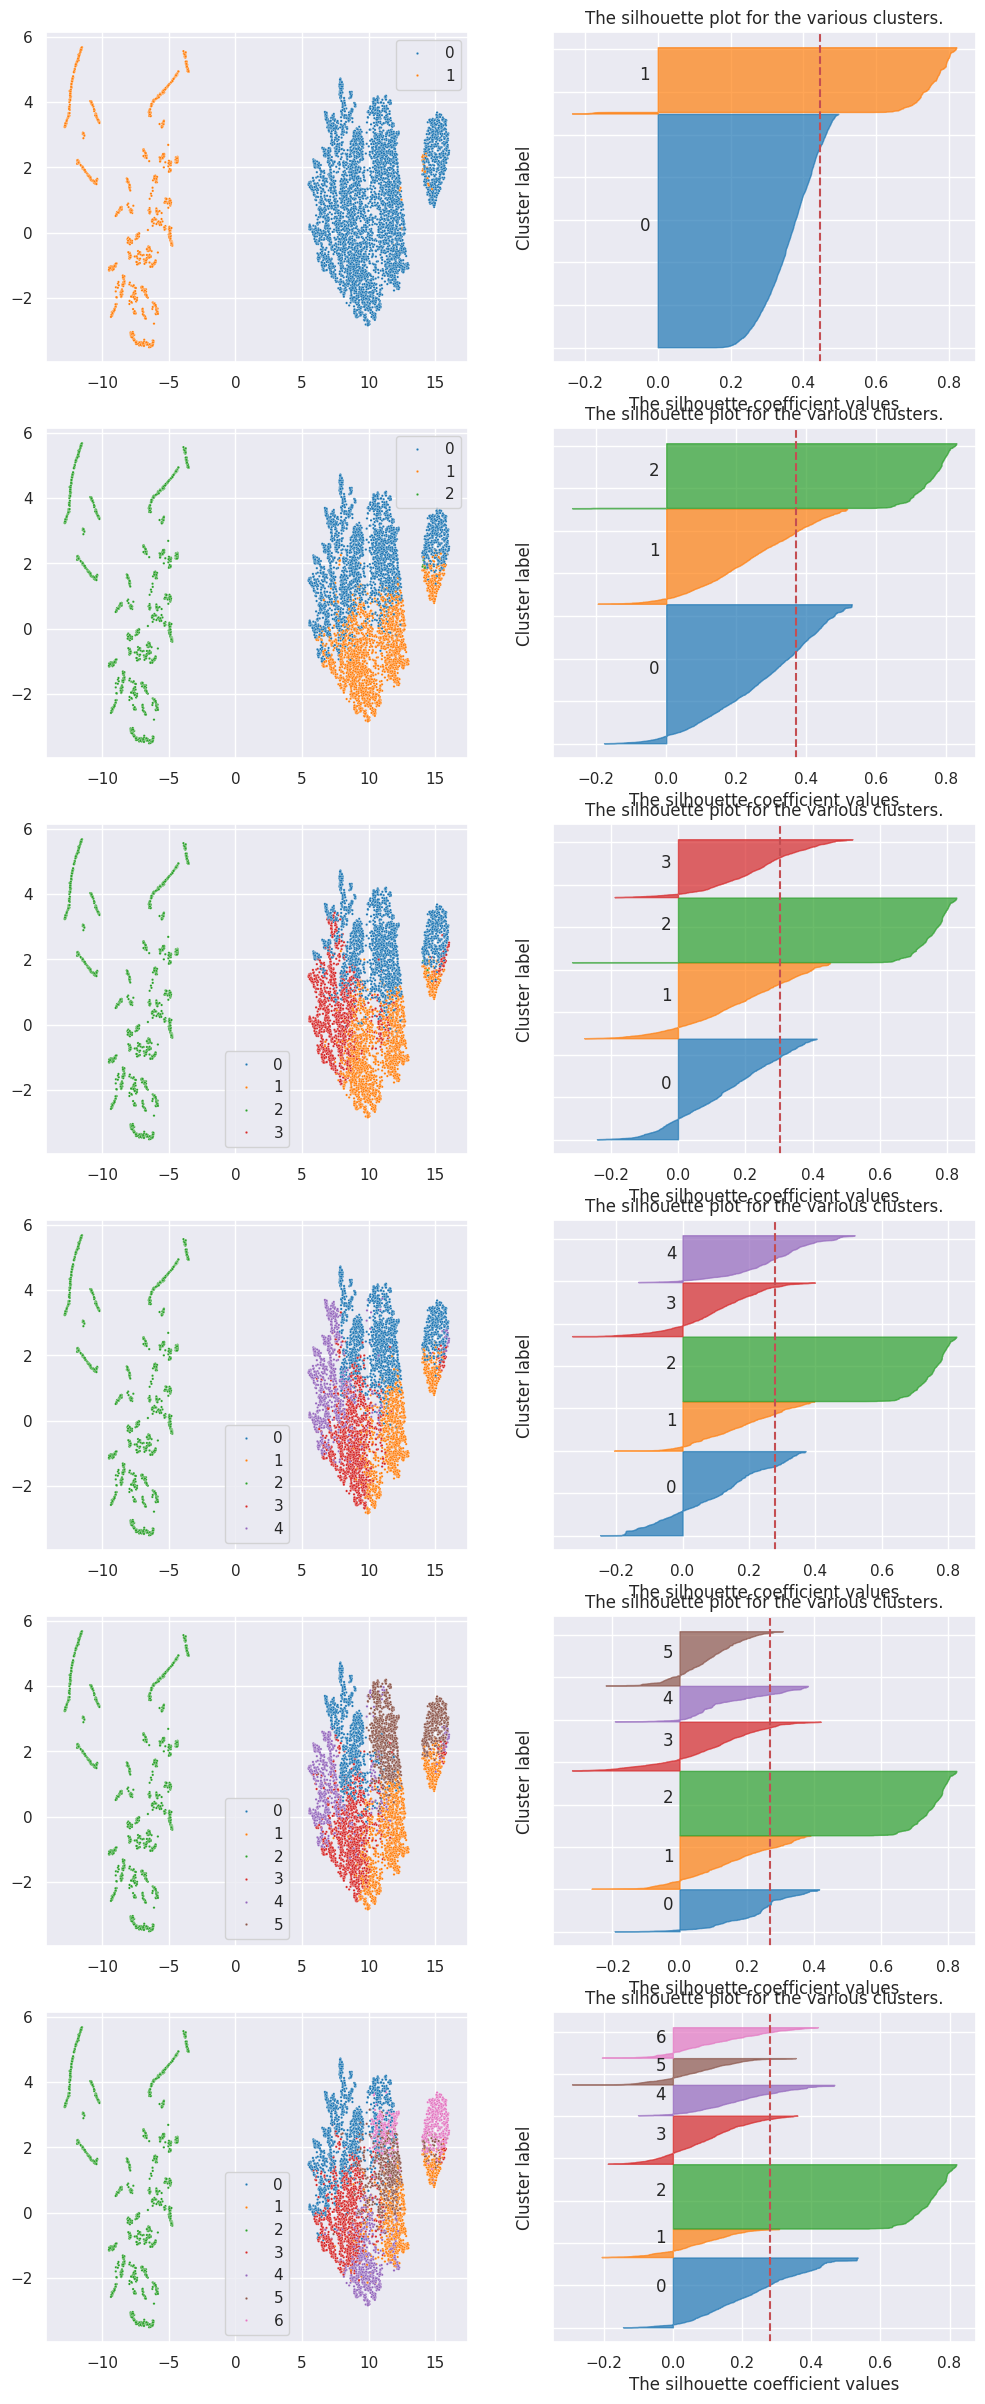

In [ ]:
# Perform clustering for multiple values of k
candidate_k = [2,3,4,5,6,7]
tab10 = list(matplotlib.colormaps['tab10'].colors)

cost_list = []
silhouette_list = []

fig, axs = plt.subplots(
    len(candidate_k), 2,
    figsize=(12, len(candidate_k)*5)
)

cluster_label_dict = {}

for i, num_clust in enumerate(candidate_k):

    print('Performing clustering for k = {}'.format(num_clust))

    # Perform clustering for current number of clusters
    kproto = KPrototypes(n_clusters=num_clust, init='Cao', n_jobs=8)

    kproto.fit(telco_df.to_numpy(), categorical=list(categ_idx))

    sns.scatterplot(
        x=umap_emb_data[:,0],
        y=umap_emb_data[:,1],
        hue=kproto.labels_,
        s=3, palette='tab10',
        ax=axs[i, 0]
    )

    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')

    curr_silhouette = plot_silouethes_score(
        data=kproto_pairwise,
        clusters=kproto.labels_,
        ax=axs[i, 1],
        distance_measure='precomputed',
        colormap=tab10
    )

    cluster_label_dict[num_clust] = kproto.labels_
    cost_list.append(kproto.cost_)
    silhouette_list.append(curr_silhouette)

plt.show()

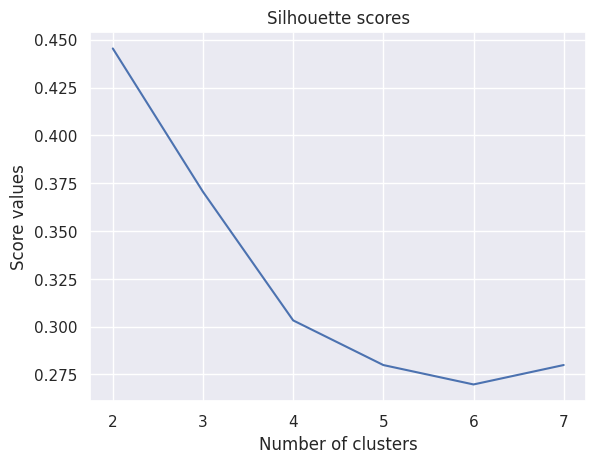

In [ ]:
plt.figure()
plt.plot(candidate_k, silhouette_list)
plt.title('Silhouette scores')
plt.xlabel('Number of clusters')
plt.ylabel('Score values')
plt.show()

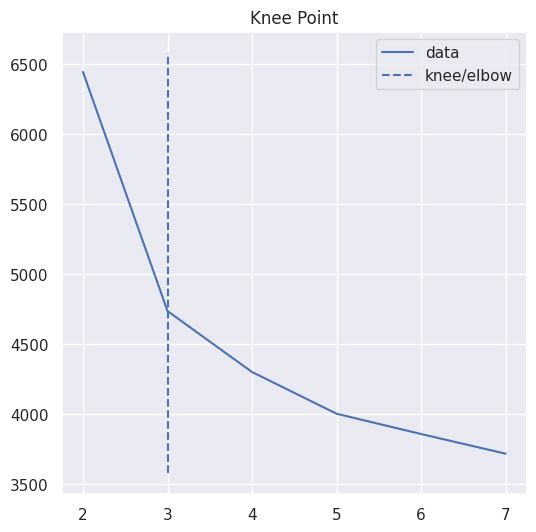

In [ ]:
# Use knee locator to find best number of clusters
kneedle = KneeLocator(
    candidate_k,
    cost_list,
    S=1.0,
    curve="convex",
    direction="decreasing"
)
kneedle.plot_knee()

In [ ]:
# uplot.points(umap_model, labels=original_df['Churn'].to_numpy())

In [ ]:
# uplot.points(umap_model, labels=cluster_label_dict[5])

In [ ]:
cluster_label_dict

{2: array([0, 0, 0, ..., 0, 0, 0], dtype=uint16),
 3: array([0, 0, 0, ..., 0, 0, 1], dtype=uint16),
 4: array([0, 0, 0, ..., 0, 0, 1], dtype=uint16),
 5: array([0, 0, 0, ..., 0, 4, 1], dtype=uint16),
 6: array([5, 5, 5, ..., 5, 0, 1], dtype=uint16),
 7: array([6, 5, 0, ..., 6, 0, 4], dtype=uint16)}

In [ ]:
# Add cluster info to df
original_df['cluster'] = cluster_label_dict[3]

In [ ]:
original_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cluster
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


---

# Calculate Silhouette Score

* per user
* per cluster
* overall

In [ ]:
kproto = KPrototypes(n_clusters=3, init='Cao', n_jobs=8)
kproto.fit(telco_df.to_numpy(), categorical=list(categ_idx))

KPrototypes(gamma=np.float64(0.15353327670350556), n_clusters=3, n_jobs=8)

In [ ]:
print(kproto.labels_.shape)
print(kproto.cluster_centroids_.shape)

(7032,)
(3, 16)


In [ ]:
print(kproto.gamma)
print(kproto.cost_)

0.15353327670350556
4736.33404834357


In [ ]:
kproto.labels_

array([0, 0, 0, ..., 0, 0, 1], dtype=uint16)

In [ ]:
kproto.cluster_centroids_

array([[0.21622821, 0.50139358, 0.28258452, 1.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 2.        ,
        0.        ],
       [0.78985261, 0.70337099, 0.7413876 , 1.        , 2.        ,
        1.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 1.        , 0.        ,
        0.        ],
       [0.4179296 , 0.02902134, 0.20900261, 1.        , 0.        ,
        2.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 2.        , 0.        , 3.        ,
        0.        ]])

## Silhouette Score (overall)

| **Parameter** | **Description** | **Potential Values** |
|---------------|-----------------|----------------------|
| **X** | Feature array or precomputed distance matrix used to compute silhouette coefficients | **array-like, shape (n_samples, n_features)**: Feature matrix<br>**array-like, shape (n_samples, n_samples)**: Precomputed distance matrix (requires `metric='precomputed'`) |
| **labels** | Cluster labels assigned to each sample | **array-like, shape (n_samples,)**: Integer labels indicating cluster membership for each sample (must have at least 2 unique labels) |
| **metric** | Distance metric to use for calculating distances between samples | **'euclidean'** (default): Standard Euclidean distance<br>**'manhattan'**: L1 distance (city block)<br>**'cosine'**: Cosine similarity-based distance<br>**'precomputed'**: Use X as precomputed distance matrix<br>**callable**: Custom distance function<br>**Other metrics**: Any valid metric from `sklearn.metrics.pairwise` |
| **sample_size** | Number of samples to use for computation (for performance on large datasets) | **None** (default): Use all samples<br>**int**: Randomly subsample this many samples for faster computation |
| **random_state** | Controls random sampling when `sample_size` is not None | **None** (default): Random sampling<br>**int**: Seed for reproducible results<br>**RandomState instance**: Random number generator object |
| **kwds** | Additional keyword arguments passed to the distance metric function | Varies by metric (e.g., `p` for Minkowski distance) |

**Returns**: `float` - Mean silhouette coefficient across all samples (range: -1 to +1, higher is better)

In [ ]:
print(telco_df.shape)
print(kproto_pairwise.shape)
print(kproto.labels_.shape)

# overall silhouette score calculation
silhouette_score(kproto_pairwise, kproto.labels_, metric='precomputed')

(7032, 16)
(7032, 7032)
(7032,)


np.float64(0.37062700263061094)

## Silhouette Samples (per observation)

| **Parameter** | **Description** | **Potential Values** |
|---------------|-----------------|----------------------|
| **X** | Feature array or precomputed distance matrix used to compute silhouette coefficients | **array-like, shape (n_samples, n_features)**: Feature matrix<br>**array-like, shape (n_samples, n_samples)**: Precomputed distance matrix (requires `metric='precomputed'`) |
| **labels** | Cluster labels assigned to each sample | **array-like, shape (n_samples,)**: Integer labels indicating cluster membership for each sample (must have at least 2 unique labels) |
| **metric** | Distance metric to use for calculating distances between samples | **'euclidean'** (default): Standard Euclidean distance<br>**'manhattan'**: L1 distance (city block)<br>**'cosine'**: Cosine similarity-based distance<br>**'precomputed'**: Use X as precomputed distance matrix<br>**callable**: Custom distance function<br>**Other metrics**: Any valid metric from `sklearn.metrics.pairwise` |
| **kwds** | Additional keyword arguments passed to the distance metric function | Varies by metric (e.g., `p` for Minkowski distance) |

**Returns**: `array, shape (n_samples,)` - Silhouette coefficient for each sample (range: -1 to +1, higher is better)

In [ ]:
silhouette_samples_array = silhouette_samples(kproto_pairwise, kproto.labels_, metric='precomputed')
print(silhouette_samples_array.shape)

(7032,)


<Axes: ylabel='Count'>

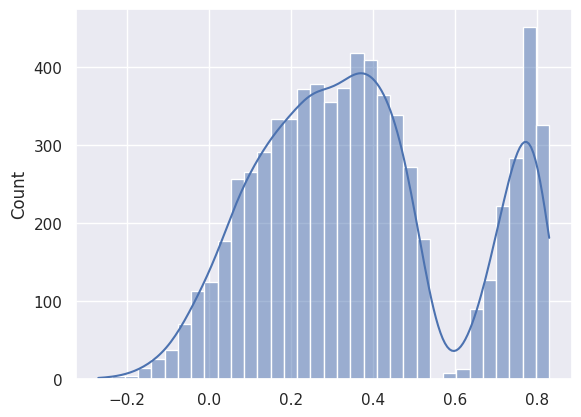

In [ ]:
sns.histplot(silhouette_samples_array, kde=True)

In [ ]:
df_silhouette = pd.DataFrame(silhouette_samples_array, columns=['silhouette_scores'])
df_silhouette['cluster_label'] = kproto.labels_
df_silhouette.describe(percentiles = np.linspace(0, 1, 11))

,silhouette_scores,cluster_label
count,7032.000000,7032.000000
mean,0.370627,0.752275
std,0.245954,0.787694
min,-0.269873,0.000000
0%,-0.269873,0.000000
10%,0.070722,0.000000
20%,0.152299,0.000000
30%,0.222233,0.000000
40%,0.281612,0.000000
50%,0.343362,1.000000


In [ ]:
df_silhouette.head()

,silhouette_scores,cluster_label
0,0.369900,0
1,0.116970,0
2,0.365481,0
3,0.055988,1
4,0.528035,0


In [ ]:
df_silhouette.groupby('cluster_label')['silhouette_scores'].mean()

,silhouette_scores
cluster_label,
0,0.276945
1,0.247569
2,0.751725


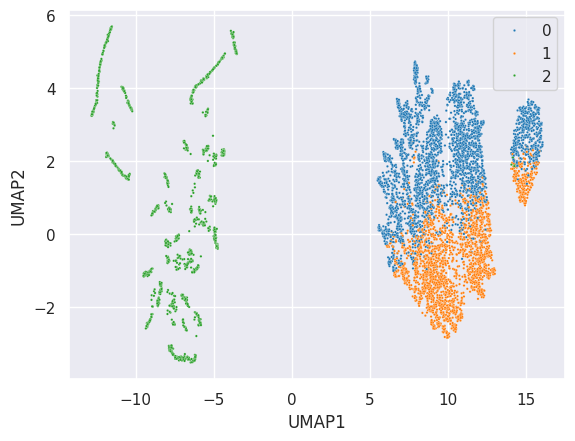

In [ ]:
sns.scatterplot(
        x=umap_emb_data[:,0],
        y=umap_emb_data[:,1],
        hue=kproto.labels_,
        s=3, palette='tab10',
    )

plt.xlabel('UMAP1');
plt.ylabel('UMAP2');

# Outlier Analysis

* check for outliers based on silhouette score distribution per cluster

In [ ]:
# check silhouette score dstribution per cluster
cluster = 0
df_silhouette[df_silhouette['cluster_label'] == cluster]['silhouette_scores'].describe(percentiles = np.linspace(0, 1, 11))

,silhouette_scores
count,3268.000000
mean,0.276945
std,0.156957
min,-0.177787
0%,-0.177787
10%,0.055934
20%,0.127168
30%,0.192310
40%,0.247763
50%,0.298201


In [ ]:
# check silhouette score dstribution per cluster
cluster = 1
df_silhouette[df_silhouette['cluster_label'] == cluster]['silhouette_scores'].describe(percentiles = np.linspace(0, 1, 11))

,silhouette_scores
count,2238.000000
mean,0.247569
std,0.151322
min,-0.196205
0%,-0.196205
10%,0.043787
20%,0.111431
30%,0.163512
40%,0.209341
50%,0.249157


In [ ]:
# check silhouette score dstribution per cluster
cluster = 2
df_silhouette[df_silhouette['cluster_label'] == cluster]['silhouette_scores'].describe(percentiles = np.linspace(0, 1, 11))

,silhouette_scores
count,1526.000000
mean,0.751725
std,0.078588
min,-0.269873
0%,-0.269873
10%,0.689062
20%,0.707712
30%,0.731924
40%,0.747693
50%,0.766095


---

# Cluster analysis

In [ ]:
original_df['cluster'].value_counts()

,count
cluster,
0,3268
1,2237
2,1527


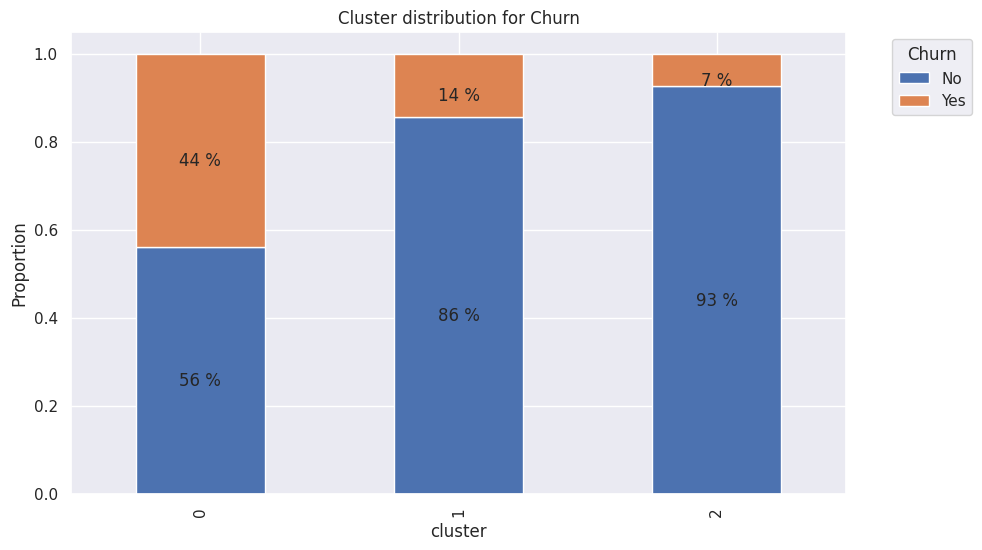

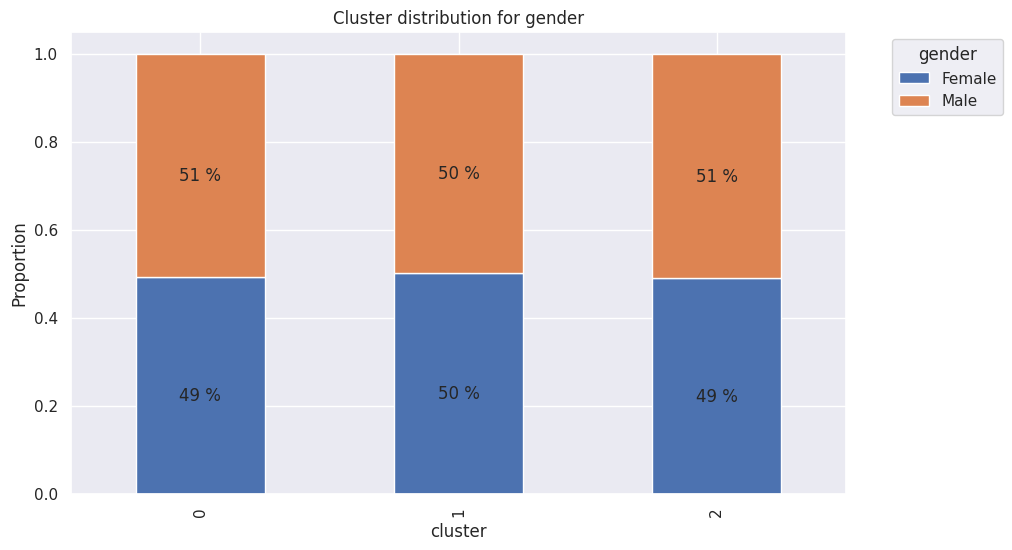

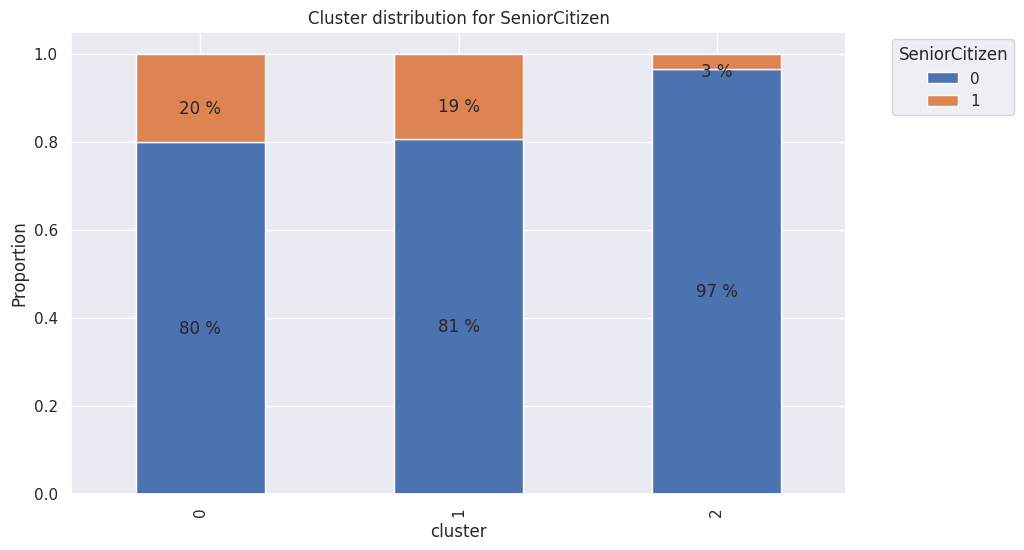

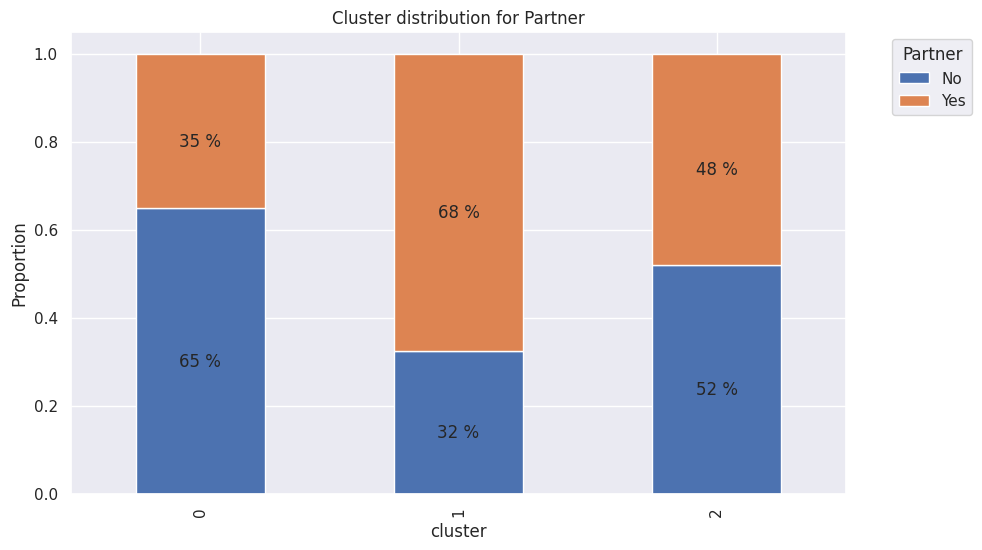

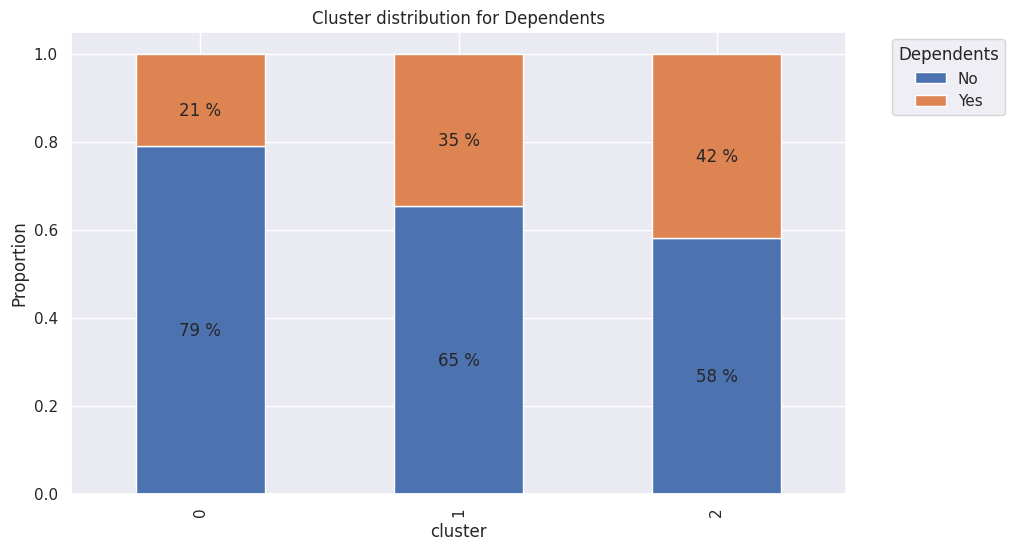

In [ ]:
# Plot other categorical data [not used during clustering]
for col in ['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']:

    if col != 'cluster':

        # Calculate proportions
        proportions = original_df.groupby(
            'cluster'
        )[col].value_counts(
            normalize=True
        ).unstack()

        # Create stacked bar plot
        ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f'Cluster distribution for {col}')
        plt.ylabel('Proportion')

        # Add legend
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get category labels
        category_labels = proportions.columns.tolist()[::-1]

        # Add percentages and category labels on the stacks
        for i, patch in enumerate(ax.patches):
            width, height = patch.get_width(), patch.get_height()
            if height > 0:  # Skip patches with height 0
                x, y = patch.get_xy()

                ax.text(x+width/2,
                        y+height/2,
                        '\n{:.0f} %'.format(height*100),
                        horizontalalignment='center',
                        verticalalignment='center')

        plt.show()

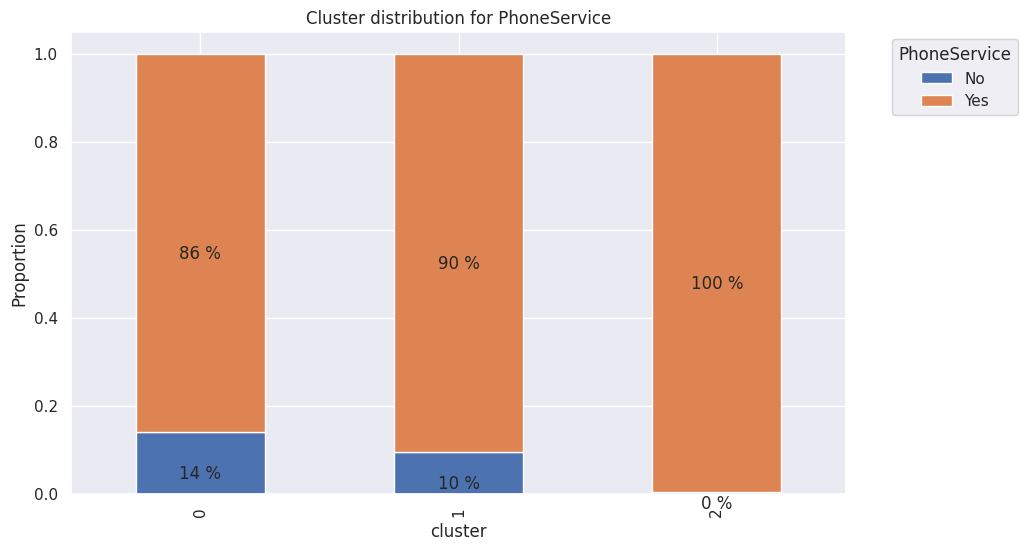

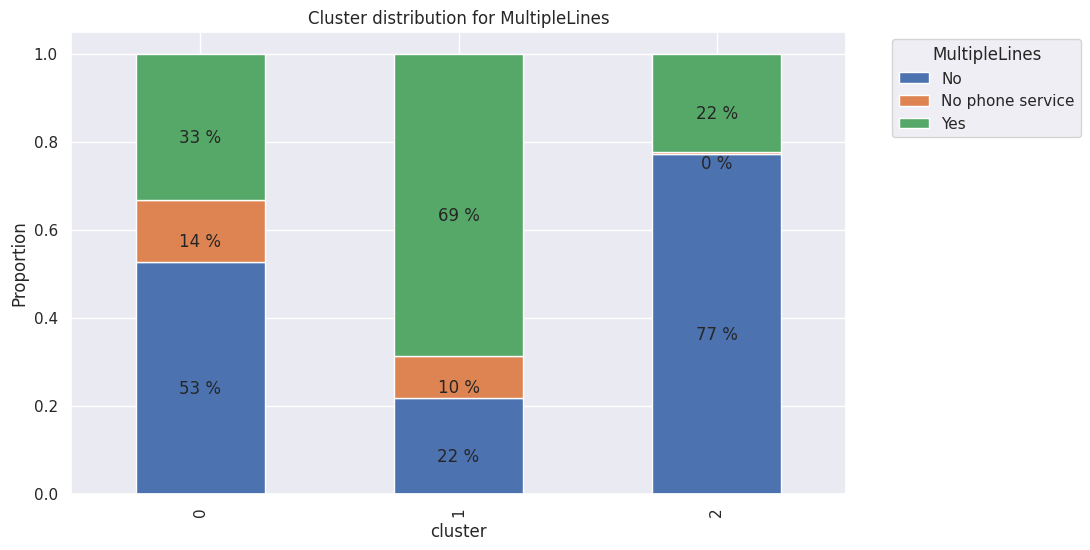

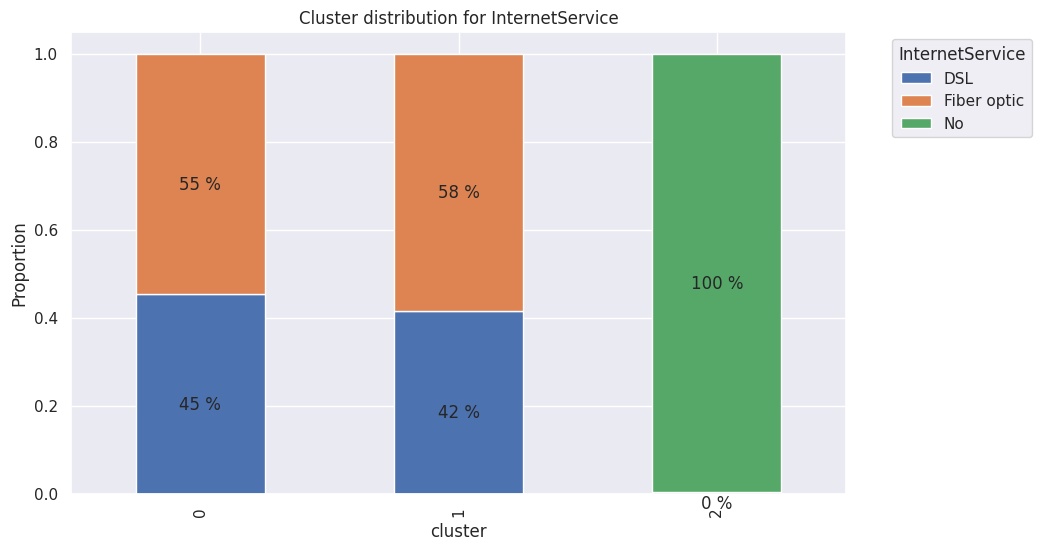

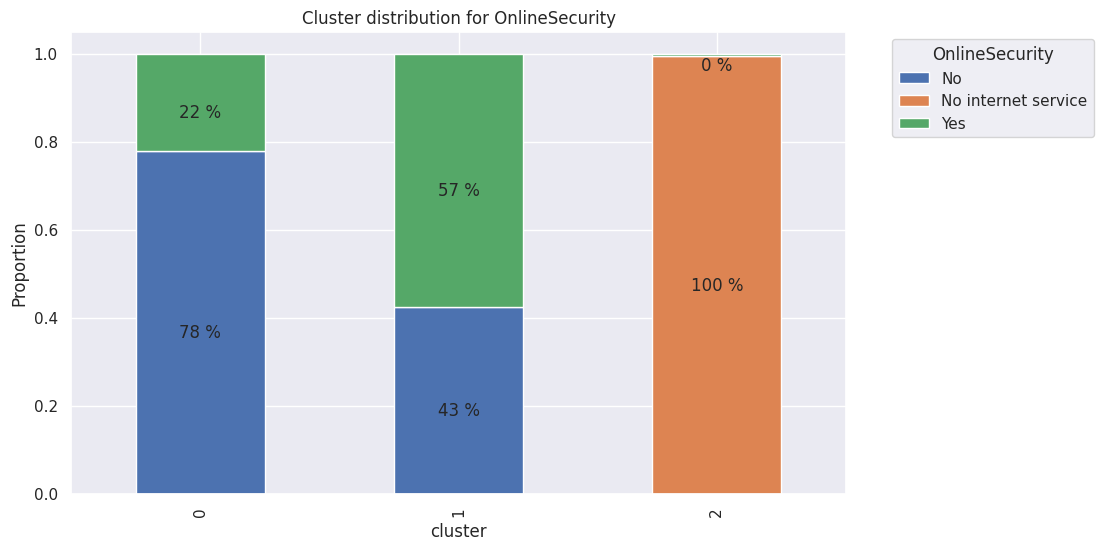

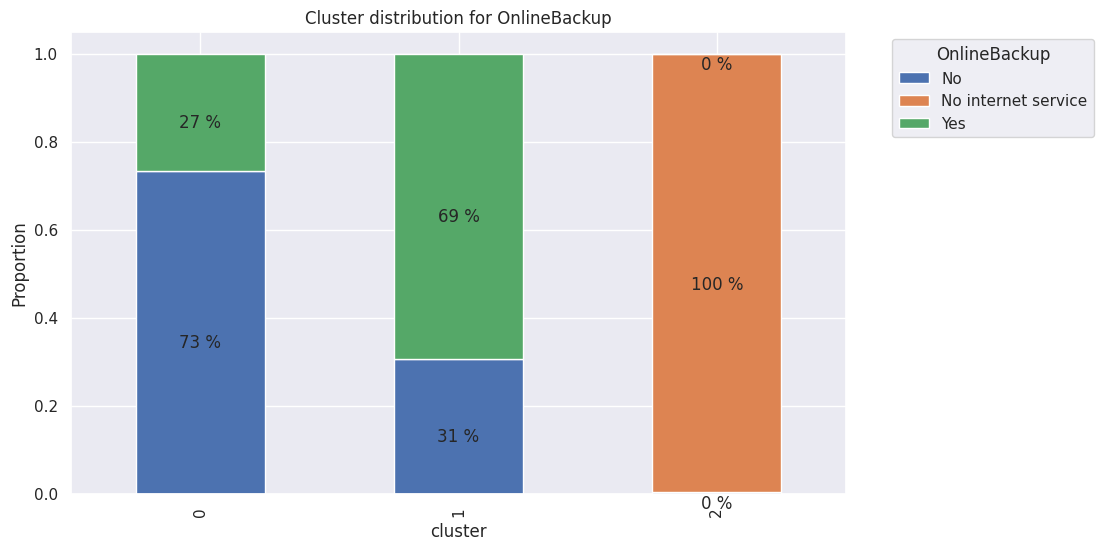

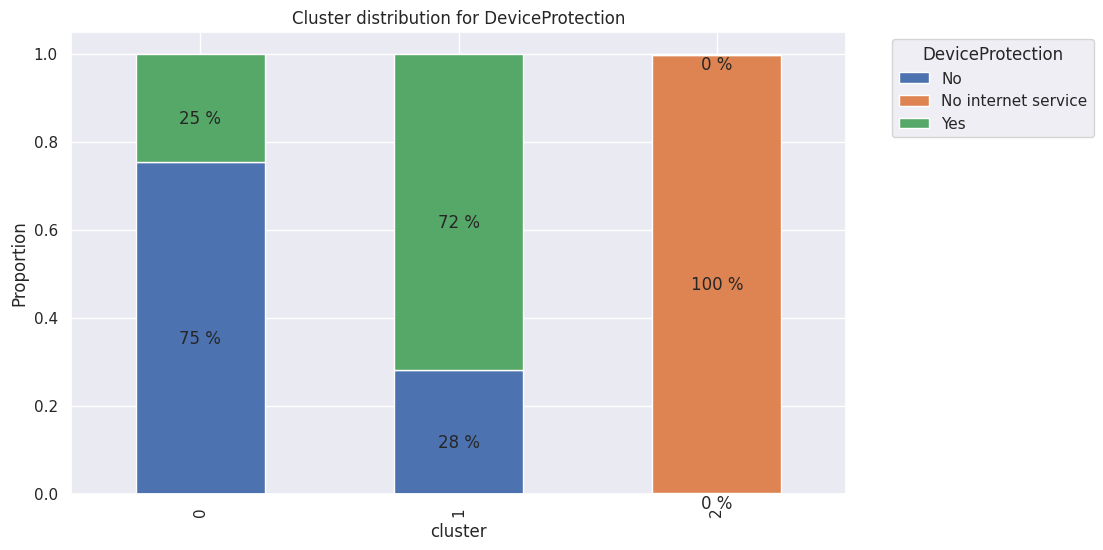

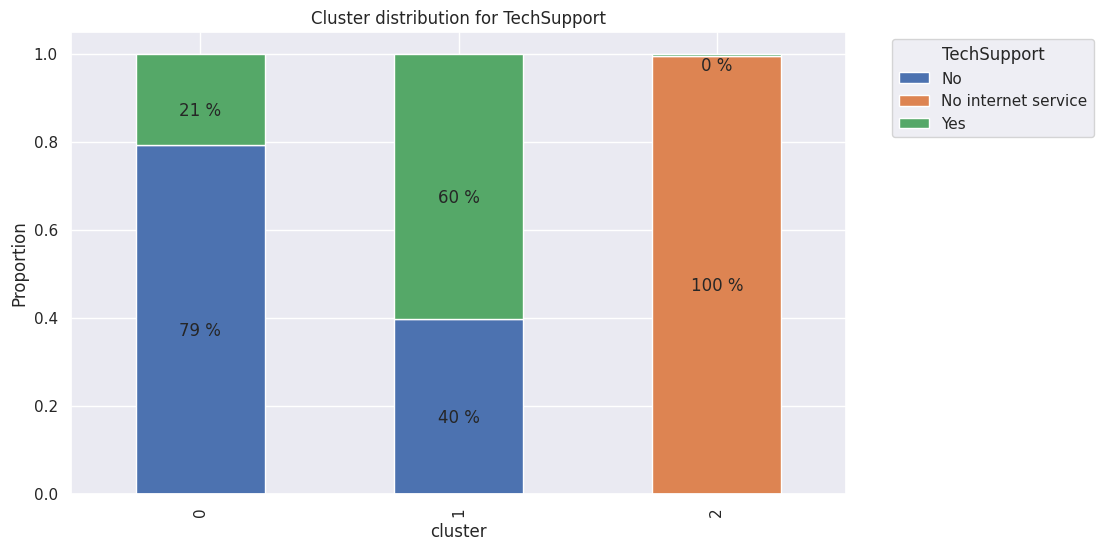

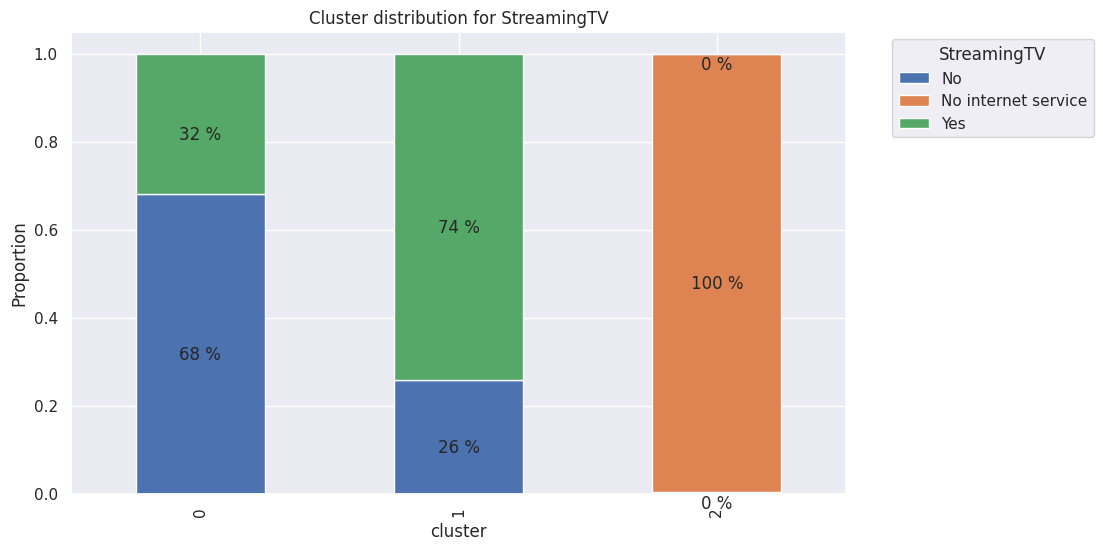

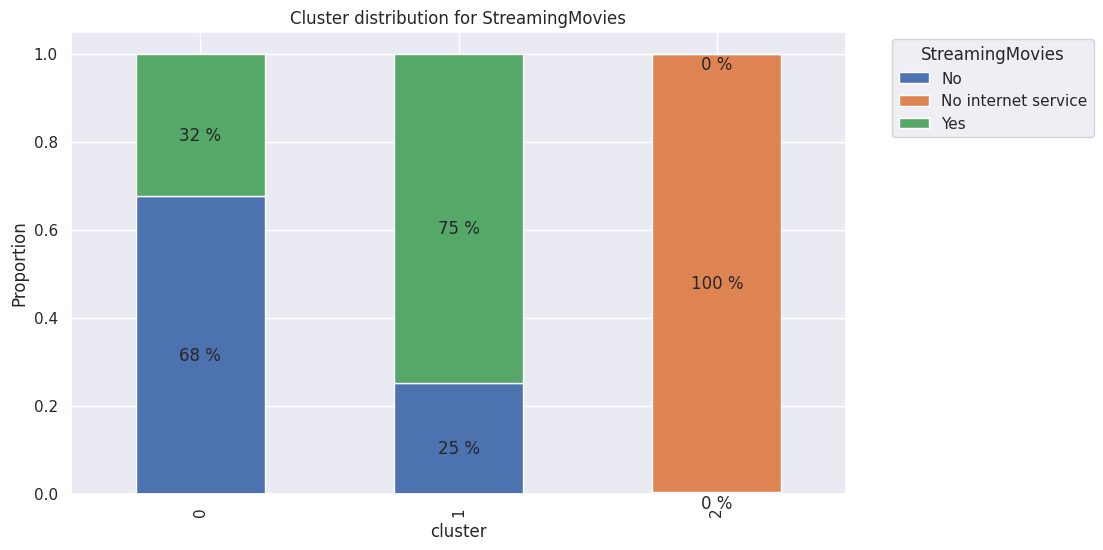

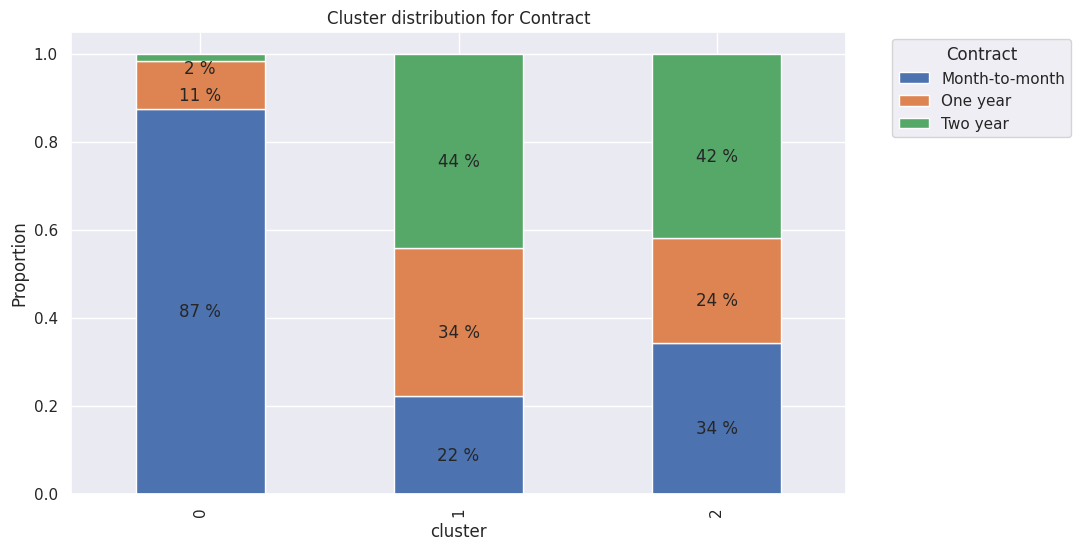

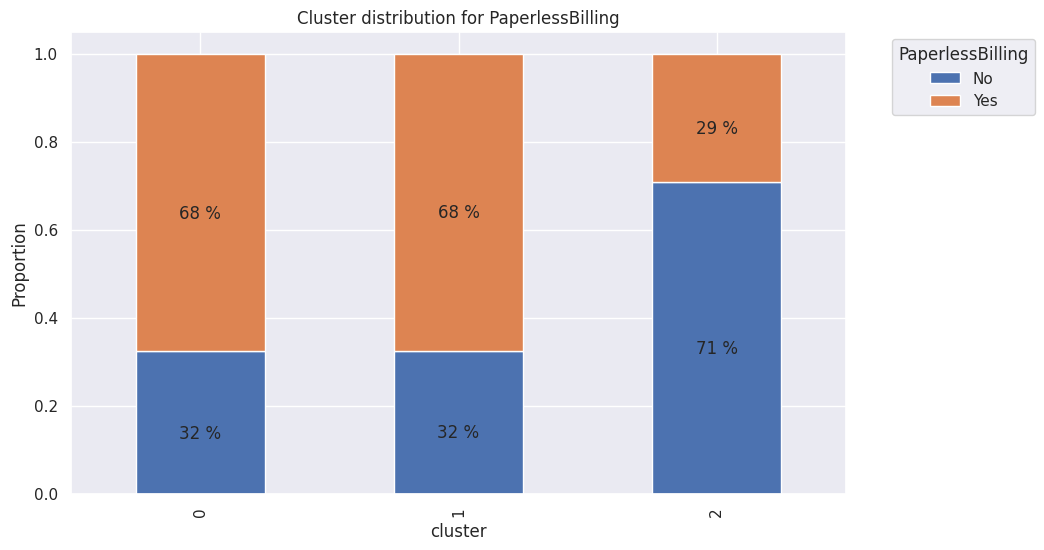

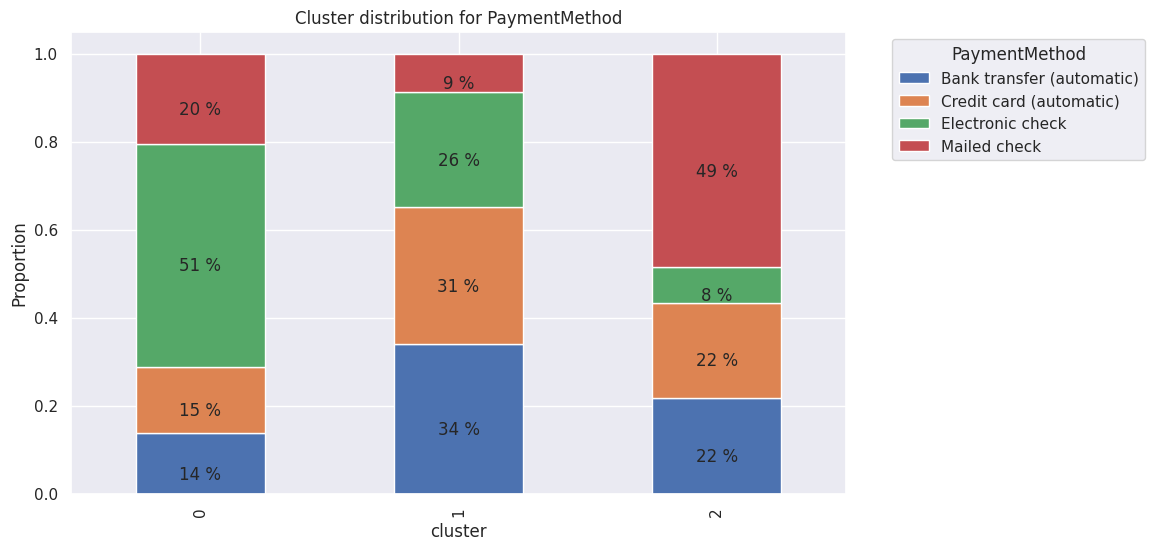

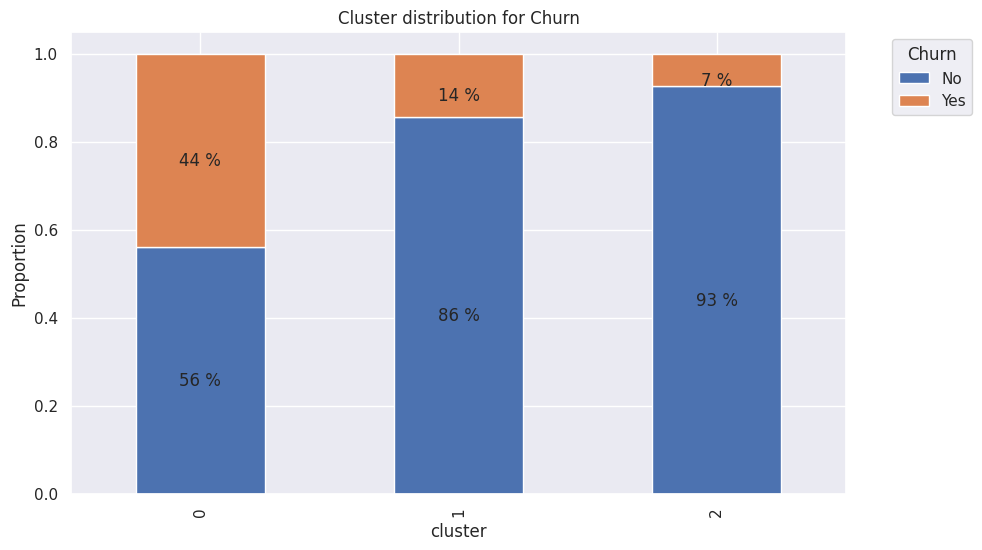

In [ ]:
# Categorical plots

for col in categ_cols:
    if col != 'cluster':

        # Calculate proportions
        proportions = original_df.groupby(
            'cluster'
        )[col].value_counts(
            normalize=True
        ).unstack()

        # Create stacked bar plot
        ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f'Cluster distribution for {col}')
        plt.ylabel('Proportion')

        # Add legend
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get category labels
        category_labels = proportions.columns.tolist()[::-1]

        # Add percentages and category labels on the stacks
        for i, patch in enumerate(ax.patches):
            width, height = patch.get_width(), patch.get_height()
            if height > 0:  # Skip patches with height 0
                x, y = patch.get_xy()

                ax.text(x+width/2,
                        y+height/2,
                        '\n{:.0f} %'.format(height*100),
                        horizontalalignment='center',
                        verticalalignment='center')

        plt.show()

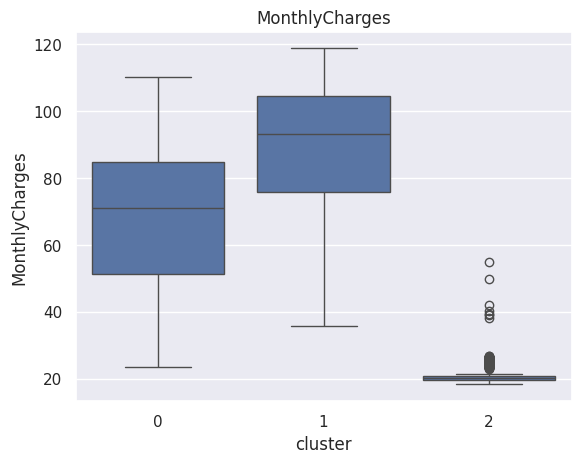

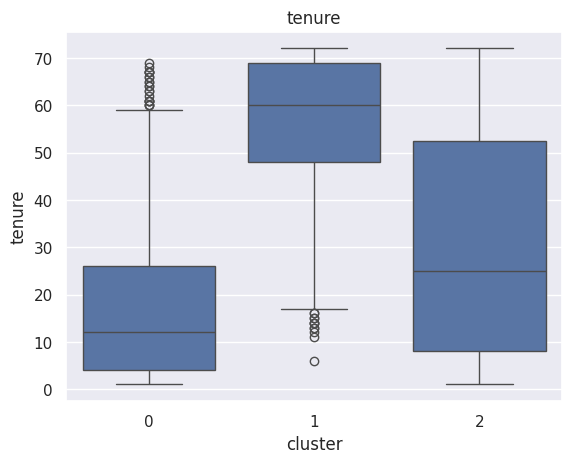

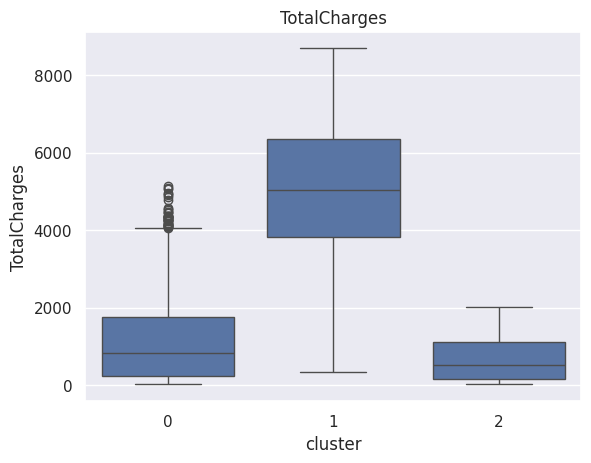

In [ ]:
# Plot numerical
for col in num_cols:

    plt.figure()
    sns.boxplot(original_df, x='cluster', y=col)
    plt.title(col)

---

# DBSCAN Clustering - Mixed Data

In [ ]:
import numpy as np

import hdbscan
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
from hdbscan.validity import validity_index

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

# Utility Functions

In [ ]:
def plot_silouethes_dens(
    data_df, clusters, colors=None, embedding_mtx=None,
    figsize=(12,5), distance_measure='euclidean'):
    """
    Plot silouethe scores and a given clustering.

    :param data_df: Dataset dataframe.
    :param clusters: Cluster ids.
    :param dendr_colors: Dendrogram colors or other color pallete.
    :param embedding_mtx: Embedding matrix that will be used for plotting the scatterplot.
    :param figsize: Figure size.
    :param distance_measure: Distance measure.
    :param legend_adjust_2: _description_, defaults to 0
    :return:
    """

    if -1 in clusters:
        clusters += 1
        legend_adjust = -1
    else:
        legend_adjust = 0

    y_lower = 10

    # Calculate average silhouette score
    silhouette_scr = silhouette_score(data_df, clusters, metric=distance_measure)

    # Calculate silhouette score for each data point
    sample_silhouette_values = silhouette_samples(data_df, clusters, metric=distance_measure)

    # Plot clustering and silouethes
    if embedding_mtx is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=figsize)

    num_clust = np.unique(clusters).shape[0]


    # Plot siluethe scores for points belonging to each cluster
    for clust_i in range(num_clust):

        # Get points bellogning to the current cluster
        ith_cluster_silhouette_values = sample_silhouette_values[
            clusters == clust_i
        ]

        # Sort points by silhouette value
        ith_cluster_silhouette_values.sort()

        # Get size of current cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        # Get upper value of y cooridnate for current cluster
        y_upper = y_lower + size_cluster_i

        # Fill values between y_lower and y_upper with silhouette score values
        # for data points

        if colors:
            color = colors[clust_i]
        else:
            color = cm.nipy_spectral(float(clust_i) / num_clust)

        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(clust_i + legend_adjust))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    # Set title and labels silhouette subplot
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_scr, color="red", linestyle="--")

    # Clear the yaxis labels / ticks
    ax1.set_yticks([])
    # Set x-ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Map cluster labels to cluster colors
    if colors:
        colors = [colors[clust_i] for clust_i in clusters]
    else:
        colors = [cm.nipy_spectral(float(clust_i) / num_clust) for clust_i in clusters]

    if embedding_mtx is not None:

        # 2nd Plot showing the actual clusters formed
        ax2.scatter(
            embedding_mtx[:, 0],
            embedding_mtx[:, 1],
            marker=".", s=30, lw=0,
            alpha=0.7, c=colors,
            edgecolor="k"
        )

        # Set title and labels for scatterplot
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("dim1")
        ax2.set_ylabel("dim2")

    # Add main title
    plt.suptitle(
        "Silhouette analysis for KMeans clustering",
        fontsize=14,
        fontweight="bold",
    )

    # Show the plot
    plt.show()

    return silhouette_scr


def print_clustering_stats(clusterer, clust_data, data_labels):
    """
    Prints clustering stats for the full dataset and
    for portion of the dataset containing non-noise data points.

    Stats are based on metrics such as DBCV, silhouette scores
    and ARI(uses ground truth information).

    :param clusterer: Fitted clustering object (DBSCAN/HDBSCAN)
    :param clust_data: Clustered dataset.
    :param data_labels: True labels.
    """

    np_labels = np.array(clusterer.labels_)
    non_noise_idx = np.where(np_labels != -1)

    non_noise_labels = np_labels[non_noise_idx]
    clust_labels_sub = data_labels[non_noise_idx]
    clust_data_sub = clust_data[non_noise_idx]
    noise_size = np_labels.shape[0] - non_noise_labels.shape[0]

    print('ARI : {}'.format(adjusted_rand_score(np_labels, data_labels)))
    print('ARI sub : {}'.format(adjusted_rand_score(non_noise_labels, clust_labels_sub)))
    print('noise size : {}'.format(noise_size))
    print('Silouethe : {}'.format(silhouette_score(clust_data, np_labels)))
    print('Silouethe sub : {}'.format(silhouette_score(clust_data_sub, clust_labels_sub)))
    print('DBCV : {}'.format(validity_index(clust_data, np_labels)))

# DBSCAN Clustering

## DBSCAN Parameters

| Parameter | Description | Common Values |
|-----------|-------------|---------------|
| `eps` | Maximum distance between two samples to be considered neighbors | 0.5 (default), depends on data scale |
| `min_samples` | Minimum number of samples in a neighborhood for a core point | 5 (default), often set to dimensions + 1 |
| `metric` | Distance metric to use | `'euclidean'` (default), `'manhattan'`, `'precomputed'` |
| `metric_params` | Additional keyword arguments for the metric function | Dict of parameters |
| `algorithm` | NN search algorithm to use | `'auto'`, `'ball_tree'`, `'kd_tree'`, `'brute'` |
| `leaf_size` | Leaf size for tree algorithms | 30 (default), affects speed/memory tradeoff |
| `p` | Power parameter for Minkowski metric | 2 (default, Euclidean) |
| `n_jobs` | Number of parallel jobs for neighbor search | None (default), -1 (all CPUs) |

## DBSCAN Attributes

| Attribute | Description |
|-----------|-------------|
| `core_sample_indices_` | Indices of core samples |
| `components_` | Copy of each core sample found by training |
| `labels_` | Cluster labels for each point (-1 for noise) |
| `n_features_in_` | Number of features seen during fit |
| `feature_names_in_` | Names of features seen during fit (if input is DataFrame) |

## DBSCAN Methods

| Method | Description |
|--------|-------------|
| `fit(X)` | Perform DBSCAN clustering from features |
| `fit_predict(X)` | Perform clustering and return cluster labels |
| `get_params()` | Get parameters for this estimator |
| `set_params(**params)` | Set parameters of this estimator |

# Obtain Initial Model Parameters

In [ ]:
print(pairwise_gower.shape)
print(telco_df.shape)
print(embedding_df.shape)

(7032, 7032)
(7032, 16)
(7032, 3)


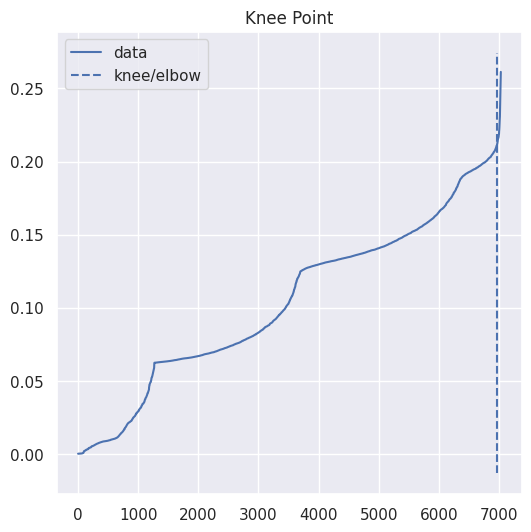

In [ ]:
min_pts = telco_df.shape[1] * 2
min_pts

nbrs = NearestNeighbors(n_neighbors=min_pts, metric="precomputed").fit(pairwise_gower)
distances, _ = nbrs.kneighbors(pairwise_gower)

sort_dist = np.sort(distances[:,-1])

kneedle = KneeLocator(
    range(sort_dist.shape[0]),
    sort_dist,
    S=1.0,
    curve="convex",
    direction="increasing"
)
kneedle.plot_knee()

# DBSCAN Clustering

In [ ]:
embedding_df.head()

,UMAP1,UMAP2,label
0,15.187618,3.118382,No
1,12.043905,1.491833,No
2,11.020074,3.317313,Yes
3,14.240722,2.032926,No
4,7.955990,4.411313,Yes


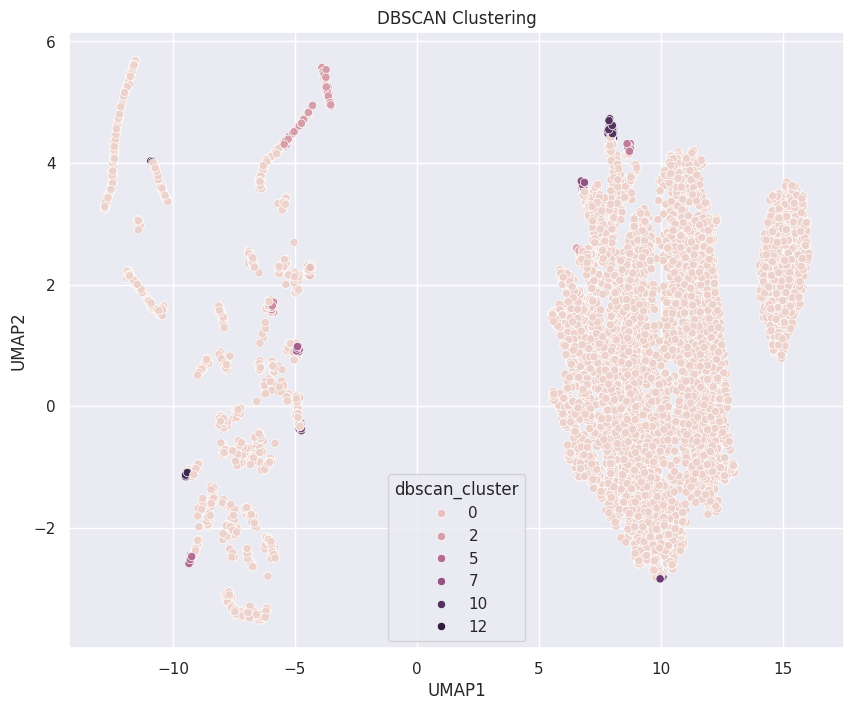

In [ ]:
dbscan = DBSCAN(eps=0.08, min_samples=10)
_ = dbscan.fit(pairwise_gower.astype(np.double))


embedding_df['dbscan_cluster'] = dbscan.labels_

plt.figure(figsize=(10,8))
sns.scatterplot(embedding_df, x='UMAP1', y='UMAP2', hue='dbscan_cluster');
plt.title('DBSCAN Clustering')
plt.show()

In [ ]:
# Evaluate the clustering
dbcv = hdbscan.validity.validity_index(
    pairwise_gower.astype(np.double),
    labels=dbscan.labels_,
    metric='precomputed',
    d = telco_df.shape[1],
    per_cluster_scores=True
)

non_noise_idx = np.where(dbscan.labels_!=-1)[0]

sil_score = silhouette_score(
    pairwise_gower[non_noise_idx,:][:, non_noise_idx],
    dbscan.labels_[non_noise_idx],
    metric='precomputed'
)

print('DBCV : {}'.format(dbcv[0]))
print('Silouethe : {}'.format(sil_score))

DBCV : 0.04633776744179886
Silouethe : 0.9747076034545898


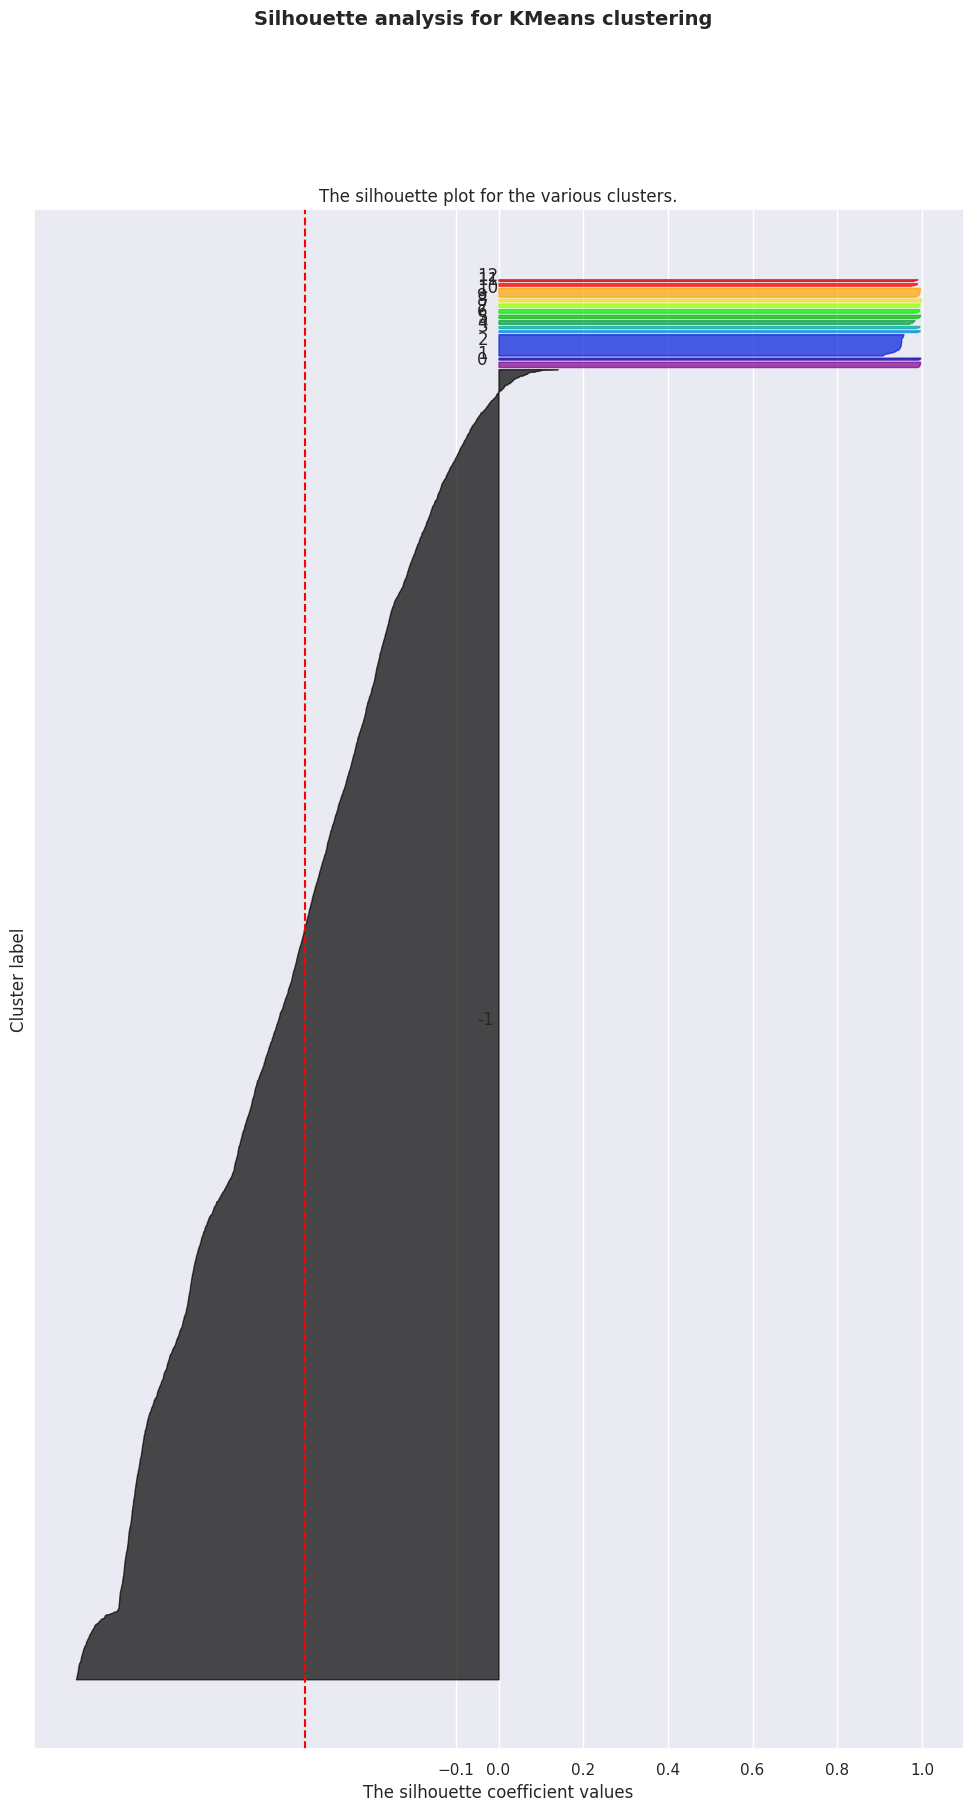

np.float64(-0.4557556336007303)

In [ ]:
plot_silouethes_dens(
    data_df = pairwise_gower.astype(np.double),
    clusters=dbscan.labels_ ,
    distance_measure='precomputed',
    figsize=(12,20),
)

# HDBSCAN Clustering

In [ ]:
# Run HDDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=30, gen_min_span_tree=True, metric='precomputed')
clusterer.fit(pairwise_gower.astype(np.double))

np.unique(clusterer.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34]),
 array([4410,   51,   46,   49,   31,   30,   38,   43,   70,   45,   91,
          30,   88,   41,  115,  138,   36,   49,   31,  242,   51,  369,
         209,   45,   33,   43,   41,  104,  111,   35,   75,   41,   70,
          38,   30,   63]))

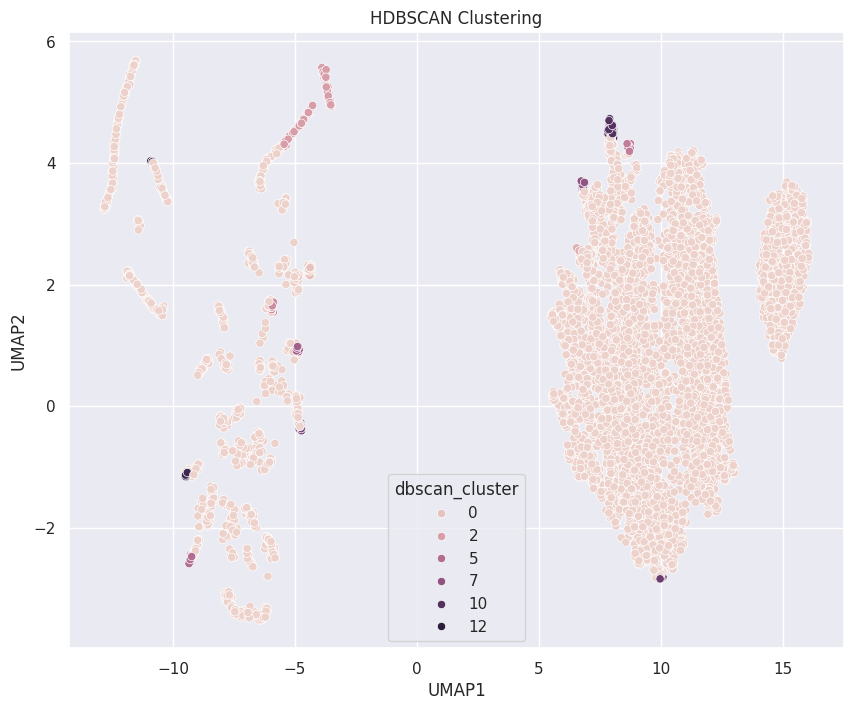

In [ ]:
embedding_df['hdbscan_cluster'] = clusterer.labels_

plt.figure(figsize=(10,8))
sns.scatterplot(embedding_df, x='UMAP1', y='UMAP2', hue='dbscan_cluster');
plt.title('HDBSCAN Clustering')
plt.show()

In [ ]:
# Evaluate the clustering
dbcv = hdbscan.validity.validity_index(
    pairwise_gower.astype(np.double),
    labels=clusterer.labels_,
    metric='precomputed',
    d = telco_df.shape[1],
    per_cluster_scores=True
)

non_noise_idx = np.where(clusterer.labels_!=-1)[0]

sil_score = silhouette_score(
    pairwise_gower[non_noise_idx,:][:, non_noise_idx],
    clusterer.labels_[non_noise_idx],
    metric='precomputed'
)

print('DBCV : {}'.format(dbcv[0]))
print('Silouethe : {}'.format(sil_score))

DBCV : 0.14647520475048795
Silouethe : 0.448285847902298
